# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [343]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


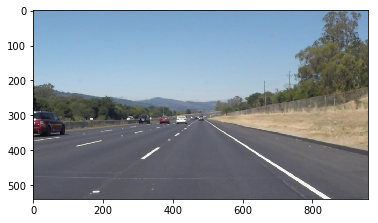

In [344]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [371]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_m=left_num=0
    right_m=right_num=0
    left_x=left_y=0
    right_x=right_y=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            m=(y2-y1)/(x2-x1)
            if(0.5<abs(m)<0.8):
                if(m>0):
                    right_m+=m
                    right_x+=(x1+x2)/2
                    right_y+=(y1+y2)/2
                    right_num+=1
                else:
                    left_m+=m
                    left_x+=(x1+x2)/2
                    left_y+=(y1+y2)/2
                    left_num+=1
    if(left_num>=1):
        left_x/=left_num
        left_y/=left_num
        left_m/=left_num
        left_c=left_y-left_m*left_x
        print ("Left x %d y %d c %f m %f" %(left_x,left_y,left_c, left_m))
        cv2.line(img, (int(left_x),int( left_y)), (int(0),int(left_c)), color, thickness)
        #cv2.line(img, (int(left_x),int( left_y)), (int(left_x-100),int(left_m*(left_x-100)+left_c)), color, thickness)
    if(right_num>=1):
        right_x/=right_num
        right_y/=right_num
        right_m/=right_num
        right_c=right_y-right_m*right_x
        #print ("Right x %d y %d c %f" %(right_x,right_y,right_c))
        #cv2.line(img, (int(right_x),int( right_y)), (int(right_x-100),(int(right_m*(right_x-100)+right_c))), color, thickness)
        #cv2.line(img, (int(right_x),int( right_y)), (int(right_x+200),(int(right_m*(right_x+200)+right_c))), color, thickness)
          
             
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [372]:
import os
imgfiles=os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

Left x 348 y 404 c 661.756949 m -0.737051
Left x 354 y 392 c 645.703380 m -0.714507
Left x 346 y 409 c 679.484848 m -0.780303
Left x 381 y 377 c 643.347487 m -0.697305
Left x 350 y 410 c 668.967193 m -0.738571
Left x 463 y 564 c 886.156069 m -0.692883
Left x 325 y 423 c 660.886820 m -0.731959


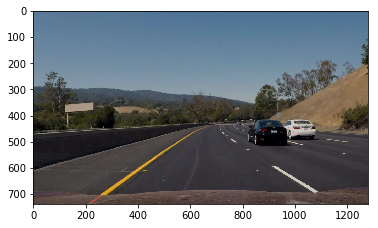

In [373]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
dir="test_images_output"
if not os.path.exists(dir):
    os.makedirs(dir)

def get_lane_line_img(image):    
    gray=grayscale(image)
    blur=gaussian_blur(gray,3)
    edges=canny(blur, 150,200)
    imshape=image.shape
    verts = np.array([[(150,imshape[0]-40),(420, 320), (520, 320), (imshape[1]-150,imshape[0]-40)]], dtype=np.int32)
    masked_edges=region_of_interest(edges,verts)
    rho = 1
    theta = np.pi/180
    threshold = 50
    min_line_len = 25
    max_line_gap = 70
    himg=hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    wimg=weighted_img(himg,image)
    return wimg
    
for imgfile in imgfiles:
    image=mpimg.imread("test_images/"+imgfile)
    lane_line_img=get_lane_line_img(image)
    plt.imsave(dir+"/"+imgfile,lane_line_img)

plt.imshow((mpimg.imread(dir+"/"+"test.jpg")))
#plt.imshow((mpimg.imread(dir+"/"+"solidWhiteRight.jpg")))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [348]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [349]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result=get_lane_line_img(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [350]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Left x 329 y 414 c 664.905037
Right x 664 y 418 c 8.168817
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



  0%|          | 0/222 [00:00<?, ?it/s]

Left x 329 y 414 c 664.905037
Right x 664 y 418 c 8.168817
Left x 329 y 414 c 653.904123
Right x 631 y 398 c 6.444867
Left x 287 y 444 c 650.638049
Right x 637 y 401 c 10.457886
Left x 388 y 367 c 639.157895
Right x 666 y 420 c 11.106061



  2%|▏         | 5/222 [00:00<00:07, 27.98it/s]

Left x 379 y 377 c 647.745268
Right x 643 y 405 c 10.601666
Left x 370 y 383 c 651.250000
Right x 627 y 394 c 9.986550



  4%|▎         | 8/222 [00:00<00:07, 26.86it/s]

Left x 398 y 362 c 650.677357
Right x 673 y 422 c 10.212252
Left x 391 y 366 c 646.184071
Right x 669 y 419 c 11.568450
Left x 382 y 372 c 644.576618
Right x 652 y 413 c 8.035175
Left x 373 y 382 c 649.734412
Right x 655 y 416 c 4.674352



  5%|▌         | 12/222 [00:00<00:07, 29.07it/s]

Left x 360 y 393 c 651.556699
Right x 634 y 405 c 8.651011
Left x 345 y 405 c 656.586005
Right x 621 y 398 c 4.585356
Left x 309 y 430 c 652.842181
Right x 636 y 408 c 1.563176
Left x 308 y 427 c 647.190211
Right x 614 y 392 c -5.345741



  8%|▊         | 18/222 [00:00<00:05, 34.16it/s]

Left x 228 y 482 c 646.868281
Right x 666 y 426 c -3.591930
Left x 390 y 368 c 649.311475
Right x 658 y 417 c -11.907686
Left x 382 y 374 c 650.811594
Right x 637 y 403 c -13.757219
Right x 638 y 404 c -14.628288
Left x 397 y 363 c 641.691364
Right x 642 y 409 c -3.062154
Left x 388 y 369 c 639.838525
Right x 639 y 407 c -1.040574
Left x 381 y 376 c 643.225836
Right x 643 y 411 c -0.887062
Left x 373 y 382 c 646.340296
Right x 648 y 414 c 0.483637
Left x 360 y 393 c 648.934253
Right x 648 y 414 c -0.262773
Left x 342 y 405 c 644.734619
Right x 647 y 413 c -1.060092



 12%|█▏        | 26/222 [00:00<00:04, 41.04it/s]

Left x 327 y 415 c 647.977258
Right x 634 y 404 c -2.874495
Left x 322 y 417 c 640.507051
Right x 634 y 404 c -2.822182
Left x 234 y 483 c 652.261291
Right x 649 y 413 c -0.652111
Left x 390 y 367 c 642.272727
Right x 655 y 417 c -1.703655
Left x 378 y 375 c 642.832168
Right x 628 y 400 c -2.813432



 15%|█▌        | 34/222 [00:00<00:03, 47.50it/s]

Left x 374 y 384 c 664.500000
Right x 622 y 395 c -1.195748
Left x 390 y 368 c 646.364573
Right x 639 y 406 c -0.981344
Left x 391 y 367 c 647.642432
Right x 651 y 413 c 0.918079
Left x 376 y 379 c 642.542916
Right x 630 y 400 c -1.531549
Left x 374 y 379 c 645.400274
Right x 643 y 407 c -0.687494
Left x 363 y 389 c 656.137222
Right x 596 y 379 c -0.401171
Left x 336 y 409 c 649.474405
Right x 634 y 405 c -1.009273
Left x 322 y 418 c 647.379397
Right x 618 y 395 c -0.847202
Left x 330 y 412 c 652.870345
Right x 614 y 391 c -7.676958
Left x 286 y 443 c 644.559108
Right x 632 y 404 c -12.727477
Left x 390 y 366 c 641.272727
Right x 623 y 397 c -7.685443



 19%|█▉        | 42/222 [00:00<00:03, 51.11it/s]

Left x 379 y 374 c 650.128571
Right x 645 y 411 c -8.617998
Left x 372 y 381 c 657.663696
Right x 639 y 405 c -5.935691



 22%|██▏       | 48/222 [00:01<00:03, 47.56it/s]

Left x 397 y 362 c 650.691881
Right x 621 y 394 c -9.230823
Left x 391 y 365 c 650.542999
Right x 632 y 401 c -6.581545
Left x 384 y 372 c 647.149964
Right x 658 y 417 c -11.920352
Left x 377 y 377 c 652.521479
Right x 638 y 404 c -12.902994
Left x 364 y 384 c 650.230456
Right x 652 y 413 c -7.701581
Left x 346 y 398 c 653.411222
Right x 652 y 414 c -13.484369


Left x 327 y 413 c 653.288563
Right x 652 y 414 c -4.801982
Left x 320 y 415 c 648.226270
Right x 636 y 404 c -13.145391
Left x 285 y 440 c 643.905180
Right x 643 y 408 c -7.286740
Left x 296 y 428 c 630.783039
Right x 681 y 431 c -1.948338
Left x 377 y 371 c 626.000000
Right x 617 y 392 c -5.921234



 24%|██▍       | 54/222 [00:01<00:03, 47.65it/s]

Left x 367 y 378 c 624.416185
Right x 633 y 403 c -11.008856
Left x 396 y 360 c 632.849531
Right x 658 y 419 c -7.693199
Left x 387 y 367 c 632.445948
Right x 624 y 398 c -0.861646
Left x 382 y 371 c 639.417411
Right x 624 y 399 c -1.874600
Left x 371 y 380 c 634.584387
Right x 660 y 423 c -2.436779



 27%|██▋       | 60/222 [00:01<00:04, 36.52it/s]

Left x 357 y 389 c 632.213416
Right x 642 y 411 c -2.833805
Left x 319 y 416 c 637.291344
Right x 629 y 403 c -10.412880
Left x 320 y 413 c 632.699028
Right x 635 y 407 c -10.117743
Left x 280 y 443 c 635.204960
Right x 634 y 407 c -9.896424



 29%|██▉       | 65/222 [00:01<00:04, 34.80it/s]

Left x 316 y 417 c 628.505318
Right x 628 y 402 c -10.374646
Left x 384 y 370 c 631.309172
Right x 657 y 420 c 2.233935
Left x 374 y 375 c 617.353333
Right x 625 y 401 c 1.979737


Left x 360 y 383 c 617.644970
Right x 636 y 409 c -3.911289
Left x 385 y 367 c 632.406148
Right x 637 y 407 c -9.949650
Left x 382 y 368 c 630.944562
Right x 652 y 418 c -11.175194
Left x 370 y 377 c 631.317075
Right x 629 y 403 c -10.390184



 31%|███       | 69/222 [00:01<00:04, 33.76it/s]

Left x 372 y 377 c 634.602000
Right x 611 y 392 c -8.656607
Left x 359 y 385 c 627.970078
Right x 648 y 416 c -12.315437



 33%|███▎      | 73/222 [00:01<00:04, 30.00it/s]

Left x 332 y 403 c 625.684437
Right x 638 y 409 c -11.956206
Left x 323 y 410 c 630.438695
Right x 641 y 412 c -11.733702
Left x 320 y 412 c 628.185659
Right x 648 y 417 c -10.319168
Left x 283 y 437 c 632.223501
Right x 659 y 423 c -8.199217



 35%|███▍      | 77/222 [00:01<00:04, 30.59it/s]

Left x 382 y 366 c 614.687023
Right x 631 y 407 c -13.331251
Left x 376 y 372 c 621.085607
Right x 645 y 416 c -17.334233
Left x 363 y 380 c 620.421554
Right x 607 y 392 c -22.715128



 36%|███▋      | 81/222 [00:02<00:04, 30.04it/s]

Left x 392 y 361 c 620.829644
Right x 625 y 404 c -17.613416
Left x 385 y 366 c 620.268217
Right x 634 y 409 c -15.926166
Left x 372 y 374 c 621.045344
Right x 616 y 398 c -17.544650


Left x 367 y 378 c 621.060450
Right x 612 y 395 c -24.873014
Left x 355 y 384 c 617.881448
Right x 611 y 393 c -11.557254
Left x 339 y 395 c 617.973946
Right x 630 y 406 c -22.326562
Left x 320 y 410 c 623.954429
Right x 616 y 398 c -20.949492



 38%|███▊      | 85/222 [00:02<00:04, 30.34it/s]

Left x 324 y 405 c 617.991806
Right x 627 y 405 c -10.951448
Left x 318 y 410 c 617.190704
Right x 643 y 415 c -11.258018



 40%|████      | 89/222 [00:02<00:04, 28.63it/s]

Left x 314 y 412 c 610.772985
Right x 608 y 392 c -23.801159
Left x 371 y 374 c 615.105960
Right x 627 y 406 c -24.245459
Left x 364 y 381 c 621.894059
Right x 644 y 417 c -23.712367



 41%|████▏     | 92/222 [00:02<00:04, 28.99it/s]

Left x 396 y 361 c 623.188859
Right x 627 y 407 c -29.643955
Left x 387 y 368 c 620.300000
Right x 610 y 395 c -26.273327
Left x 381 y 372 c 623.620677
Right x 614 y 397 c -25.308154



 43%|████▎     | 95/222 [00:02<00:04, 28.68it/s]

Left x 372 y 378 c 624.421384
Right x 640 y 415 c -38.954230
Left x 354 y 390 c 627.013600
Right x 622 y 401 c -31.252846
Left x 339 y 399 c 623.134704
Right x 640 y 414 c -39.882353
Left x 306 y 421 c 623.730902
Right x 613 y 393 c -38.647348



 45%|████▍     | 99/222 [00:02<00:04, 29.80it/s]

Left x 318 y 411 c 620.284483
Right x 666 y 428 c -39.039942
Left x 289 y 431 c 620.081714
Right x 625 y 401 c -36.716985
Left x 381 y 370 c 631.613484
Right x 644 y 413 c -38.115263



 46%|████▋     | 103/222 [00:02<00:03, 30.88it/s]

Right x 645 y 414 c -34.854053
Left x 367 y 379 c 616.526627
Right x 654 y 422 c -37.583805
Left x 396 y 363 c 610.131579
Right x 638 y 411 c -29.277106
Left x 392 y 368 c 627.276467
Right x 656 y 423 c -27.512142



 48%|████▊     | 107/222 [00:02<00:03, 31.45it/s]

Left x 382 y 373 c 632.348800
Right x 639 y 412 c -30.271923
Left x 375 y 377 c 635.299428
Right x 611 y 391 c -30.671190
Left x 364 y 385 c 637.879918
Right x 666 y 427 c -28.570864
Left x 342 y 400 c 636.733146
Right x 626 y 400 c -29.906222



 50%|█████     | 111/222 [00:03<00:03, 33.39it/s]

Left x 315 y 419 c 633.449663
Right x 656 y 421 c -29.713404
Left x 310 y 423 c 635.368014
Right x 652 y 419 c -30.535522
Left x 230 y 478 c 633.411765
Right x 650 y 416 c -27.582860



 52%|█████▏    | 115/222 [00:03<00:03, 32.64it/s]

Left x 325 y 410 c 626.162531
Right x 648 y 413 c -23.890637
Right x 629 y 402 c -28.489591
Right x 634 y 405 c -27.591097
Left x 397 y 361 c 635.721181
Right x 655 y 416 c -30.447789


Left x 392 y 365 c 633.668033
Right x 643 y 408 c -23.140504
Left x 384 y 370 c 628.820887
Right x 640 y 406 c -20.896228
Left x 376 y 375 c 629.338292
Right x 634 y 403 c -20.613228



 56%|█████▌    | 124/222 [00:03<00:02, 36.79it/s]

Left x 336 y 402 c 636.222441
Right x 635 y 405 c -22.668251
Left x 343 y 399 c 634.571645
Right x 660 y 419 c -14.396096
Left x 291 y 434 c 637.866368
Right x 632 y 402 c -7.919305
Left x 325 y 412 c 626.015599
Right x 618 y 394 c -7.140817
Left x 307 y 424 c 637.008333
Right x 648 y 413 c -10.212282
Left x 273 y 447 c 630.409973
Right x 639 y 406 c -8.283136
Left x 386 y 372 c 636.906911
Right x 639 y 406 c -10.371911
Left x 375 y 380 c 639.131300
Right x 651 y 415 c -5.262934



 59%|█████▉    | 132/222 [00:03<00:02, 36.58it/s]

Left x 383 y 375 c 637.601254
Right x 641 y 406 c -1.497933
Left x 397 y 366 c 638.014519
Right x 626 y 397 c -2.963230
Left x 390 y 371 c 645.017997
Right x 638 y 403 c -1.088863
Left x 376 y 381 c 644.624231
Right x 651 y 413 c -0.826187
Left x 369 y 387 c 645.736838
Right x 638 y 407 c -3.711929
Left x 354 y 397 c 642.703342
Right x 641 y 406 c 1.122757
Left x 337 y 410 c 646.409444
Right x 642 y 408 c -2.374318
Left x 324 y 416 c 645.227739
Right x 641 y 406 c -2.150018
Left x 320 y 419 c 648.456126
Right x 646 y 408 c -5.344249



 63%|██████▎   | 140/222 [00:03<00:02, 36.95it/s]

Left x 281 y 446 c 640.527556
Right x 631 y 397 c -5.999882
Left x 389 y 370 c 647.843595
Right x 649 y 408 c -4.986550
Left x 380 y 376 c 646.121646
Right x 623 y 392 c -4.848767
Left x 369 y 385 c 648.549758
Right x 626 y 395 c -4.190649
Left x 399 y 364 c 647.988820
Right x 646 y 409 c -3.606989
Left x 393 y 370 c 649.996606
Right x 646 y 409 c -0.921196
Left x 384 y 378 c 656.695585
Right x 631 y 400 c -1.121679
Left x 374 y 385 c 652.089024
Right x 661 y 420 c -1.689420



 67%|██████▋   | 148/222 [00:04<00:02, 34.69it/s]

Left x 338 y 412 c 656.765716
Right x 645 y 409 c -1.930072
Left x 344 y 407 c 660.529063
Right x 642 y 408 c -4.466815
Left x 328 y 418 c 662.890940
Right x 645 y 407 c -2.246591
Left x 306 y 432 c 657.655860
Right x 651 y 409 c -2.464119
Left x 233 y 485 c 656.201923
Right x 662 y 416 c -4.750775
Right x 630 y 395 c 6.753534
Left x 384 y 380 c 668.000000
Right x 668 y 418 c 1.635449



 68%|██████▊   | 152/222 [00:04<00:02, 28.46it/s]

Left x 404 y 361 c 642.715686
Right x 641 y 402 c -5.847363
Left x 399 y 367 c 657.834676
Right x 653 y 410 c -3.641823
Left x 395 y 370 c 658.508654
Right x 669 y 419 c -3.358122
Left x 391 y 371 c 653.850725
Right x 638 y 400 c -2.845620



 70%|███████   | 156/222 [00:04<00:02, 30.51it/s]

Left x 375 y 384 c 656.932362
Right x 658 y 412 c -5.103569
Left x 360 y 395 c 660.419454
Right x 668 y 417 c -7.187949


Left x 346 y 404 c 656.569520
Right x 667 y 416 c -1.218936
Left x 326 y 420 c 666.161715
Right x 636 y 397 c 5.763387
Left x 331 y 414 c 651.353387
Right x 661 y 414 c 4.660187



 72%|███████▏  | 160/222 [00:04<00:02, 26.31it/s]

Left x 237 y 487 c 658.811189
Right x 633 y 394 c 7.036495



 73%|███████▎  | 163/222 [00:04<00:02, 27.14it/s]

Right x 634 y 396 c 10.196945
Left x 387 y 377 c 669.864865
Right x 621 y 388 c 14.386345
Left x 375 y 386 c 668.352941
Right x 616 y 385 c 15.111817
Left x 407 y 364 c 676.915747
Right x 647 y 404 c 18.156118
Left x 400 y 370 c 675.998033
Right x 617 y 385 c 22.163231


Left x 391 y 376 c 660.871429
Right x 642 y 401 c 21.912011



 77%|███████▋  | 170/222 [00:04<00:01, 28.23it/s]

Left x 382 y 385 c 679.496202
Right x 631 y 395 c 23.952134
Left x 356 y 406 c 681.710751
Right x 624 y 390 c 24.711821
Left x 345 y 412 c 676.161807
Right x 641 y 402 c 21.532039
Left x 340 y 412 c 668.240343
Right x 642 y 403 c 21.636263
Left x 341 y 413 c 670.233766
Right x 639 y 400 c 23.033619


Left x 341 y 414 c 667.385363
Right x 621 y 388 c 26.874803
Right x 620 y 389 c 23.160921



 79%|███████▉  | 176/222 [00:05<00:01, 26.28it/s]

Left x 386 y 378 c 677.789855
Right x 633 y 397 c 21.821865
Left x 378 y 385 c 681.217391
Right x 596 y 374 c 22.473283
Left x 404 y 365 c 667.893204
Right x 628 y 393 c 9.216627


Left x 400 y 369 c 671.899160
Right x 609 y 382 c 22.452337
Left x 392 y 375 c 677.113371
Right x 644 y 403 c 16.720025



 81%|████████  | 179/222 [00:05<00:01, 25.83it/s]

Left x 383 y 381 c 680.236255
Right x 618 y 386 c 15.520516
Left x 370 y 391 c 681.113636
Right x 639 y 398 c 12.355873
Left x 353 y 404 c 680.652174
Right x 641 y 399 c 12.707266
Left x 339 y 415 c 681.239347
Right x 626 y 389 c 8.432133
Left x 343 y 411 c 679.339207


 82%|████████▏ | 183/222 [00:05<00:01, 27.84it/s]


Right x 614 y 382 c 7.442126
Left x 325 y 425 c 675.756917
Right x 667 y 415 c 8.132209
Right x 629 y 392 c 5.289852



 84%|████████▍ | 186/222 [00:05<00:01, 26.06it/s]

Left x 386 y 377 c 677.852941
Right x 638 y 397 c 5.714217
Left x 376 y 384 c 677.333333
Right x 638 y 398 c 19.997888
Left x 402 y 364 c 677.560000
Right x 630 y 391 c 19.823264



 86%|████████▌ | 191/222 [00:05<00:01, 29.97it/s]

Left x 398 y 365 c 675.444444
Right x 623 y 386 c 18.840883
Left x 388 y 371 c 672.777778
Right x 583 y 361 c 23.260350
Left x 381 y 379 c 664.750000
Right x 587 y 364 c 24.797722
Left x 369 y 390 c 668.331429
Right x 606 y 375 c 29.792367
Left x 349 y 408 c 672.394742
Right x 616 y 383 c 21.531589
Left x 343 y 413 c 672.252765
Right x 625 y 389 c 23.135009
Left x 343 y 413 c 671.495652
Right x 622 y 389 c 18.894043
Left x 326 y 426 c 666.783347
Right x 602 y 378 c 27.263631



 89%|████████▊ | 197/222 [00:05<00:00, 34.07it/s]

Right x 599 y 375 c 27.353693
Right x 641 y 400 c 20.349405
Left x 369 y 390 c 677.664430
Right x 614 y 383 c 21.558482



 91%|█████████ | 202/222 [00:05<00:00, 36.49it/s]

Left x 402 y 367 c 680.560000
Right x 611 y 383 c 27.227303
Left x 394 y 370 c 678.137615
Right x 604 y 377 c 21.518256
Left x 391 y 373 c 668.208955
Right x 591 y 368 c 32.927741
Left x 384 y 380 c 666.213840
Right x 623 y 388 c 20.577815
Left x 365 y 394 c 669.165680
Right x 621 y 386 c 20.413464
Left x 350 y 405 c 669.669951


 93%|█████████▎| 206/222 [00:06<00:00, 36.07it/s]


Right x 607 y 377 c 27.127971
Left x 336 y 415 c 673.437229
Right x 589 y 366 c 32.532784
Left x 341 y 412 c 669.976574
Right x 581 y 361 c 30.566227


Left x 247 y 484 c 672.190476
Right x 578 y 359 c 36.705934
Right x 589 y 366 c 31.444190
Right x 583 y 363 c 32.141233



 95%|█████████▍| 210/222 [00:06<00:00, 30.58it/s]

Right x 574 y 359 c 32.097711
Right x 602 y 375 c 31.764727
Left x 396 y 370 c 667.000000
Right x 604 y 377 c 33.929988



 97%|█████████▋| 215/222 [00:06<00:00, 32.85it/s]

Left x 390 y 375 c 668.609023
Right x 621 y 388 c 33.957366
Left x 361 y 397 c 678.522124
Right x 622 y 388 c 34.154650
Left x 375 y 387 c 670.671807
Right x 632 y 395 c 33.319270
Left x 312 y 435 c 678.750000
Right x 634 y 396 c 33.866615
Left x 291 y 450 c 679.053941
Right x 623 y 389 c 34.947906



100%|█████████▉| 221/222 [00:06<00:00, 33.75it/s]

Left x 345 y 409 c 670.351152
Right x 618 y 386 c 29.851862
Left x 244 y 485 c 670.027027
Right x 608 y 380 c 26.704097
Right x 611 y 383 c 28.752808


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 9.71 s, sys: 176 ms, total: 9.89 s
Wall time: 7.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [351]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [352]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Left x 322 y 409 c 607.794783
Right x 654 y 420 c -30.409093
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



  0%|          | 3/682 [00:00<00:29, 23.28it/s]

Left x 322 y 409 c 607.794783
Right x 654 y 420 c -30.409093
Left x 300 y 424 c 610.162461
Right x 672 y 432 c -36.458556
Left x 317 y 414 c 612.136994
Right x 643 y 412 c -24.659272
Left x 322 y 411 c 616.690916
Right x 582 y 372 c -34.734513
Left x 317 y 415 c 615.969088
Right x 588 y 374 c -22.101346


Left x 318 y 416 c 617.147084
Right x 596 y 380 c -30.307686



  2%|▏         | 11/682 [00:00<00:23, 28.49it/s]

Left x 311 y 421 c 620.500567
Right x 589 y 374 c -23.115529
Left x 325 y 413 c 623.123617
Right x 580 y 367 c -19.679790
Left x 332 y 407 c 623.466168
Right x 588 y 372 c -16.945472
Left x 322 y 413 c 625.315171
Right x 598 y 377 c -16.935291
Left x 315 y 418 c 626.167289
Right x 609 y 384 c -11.574167
Left x 356 y 392 c 629.558678
Right x 621 y 393 c -10.671368
Left x 350 y 396 c 629.821520
Right x 678 y 428 c -17.794708
Left x 348 y 398 c 630.363557
Right x 666 y 422 c -14.046131
Left x 317 y 419 c 627.725329
Right x 706 y 445 c -8.532164
Left x 355 y 393 c 638.207385
Right x 702 y 444 c -8.710453
Left x 313 y 423 c 638.247617
Right x 590 y 369 c 3.700000
Left x 321 y 418 c 639.732079


  4%|▎         | 24/682 [00:00<00:17, 38.70it/s]


Right x 593 y 377 c -26.424837
Left x 296 y 437 c 642.429782
Right x 610 y 385 c -12.459243
Left x 319 y 417 c 636.347829
Right x 581 y 365 c -10.055556
Left x 323 y 415 c 637.914340
Right x 593 y 373 c -3.823995
Left x 316 y 419 c 637.610615
Right x 601 y 377 c -3.359589
Left x 340 y 402 c 636.715854
Right x 606 y 381 c -11.174110
Left x 353 y 391 c 634.759254
Right x 622 y 390 c -4.526609
Left x 316 y 421 c 638.878216
Right x 641 y 403 c -2.597358
Left x 322 y 417 c 641.751363
Right x 674 y 424 c 8.565127
Left x 338 y 407 c 644.453872
Right x 727 y 456 c 5.776234
Left x 345 y 401 c 650.253396
Right x 708 y 443 c 19.220654



  5%|▌         | 36/682 [00:00<00:14, 45.39it/s]

Left x 340 y 403 c 643.934212
Right x 684 y 428 c -5.511899
Left x 311 y 424 c 640.337093
Right x 602 y 374 c -1.272727
Left x 306 y 428 c 645.698341
Right x 606 y 375 c -15.581395
Left x 316 y 421 c 648.698127
Right x 578 y 358 c -5.355372
Left x 345 y 400 c 651.088091
Right x 583 y 362 c -17.347303
Left x 338 y 405 c 655.866346
Right x 608 y 378 c 1.792045
Left x 329 y 411 c 653.128502
Right x 604 y 376 c -9.324766
Left x 300 y 432 c 650.909713
Right x 617 y 383 c -8.550739
Left x 309 y 427 c 651.344873
Right x 630 y 391 c -10.903425
Left x 298 y 435 c 655.901298
Right x 720 y 451 c 4.893435
Left x 313 y 424 c 658.826297


  6%|▌         | 41/682 [00:00<00:15, 42.04it/s]


Right x 713 y 446 c 2.214120
Left x 343 y 398 c 652.731228
Right x 757 y 473 c 1.176471
Left x 326 y 412 c 653.592536
Right x 653 y 407 c -3.323884
Left x 340 y 401 c 654.554247
Right x 596 y 368 c -5.319728
Left x 329 y 409 c 652.947361
Right x 606 y 374 c -1.512048
Left x 337 y 404 c 651.142932
Right x 581 y 362 c -9.555844
Left x 339 y 404 c 655.038675
Right x 580 y 362 c -5.453069



  7%|▋         | 51/682 [00:01<00:16, 38.40it/s]

Left x 333 y 408 c 654.396599
Right x 591 y 369 c 3.367804
Left x 361 y 387 c 658.076219
Right x 602 y 377 c -1.280164
Left x 335 y 407 c 661.650349
Right x 606 y 378 c 0.911346
Left x 342 y 401 c 655.742435
Right x 624 y 391 c 1.446684
Left x 332 y 408 c 654.416139
Right x 652 y 406 c 9.808294
Left x 353 y 392 c 655.424041
Right x 676 y 422 c 8.443191
Left x 339 y 403 c 651.993843
Right x 701 y 438 c 12.610040



  8%|▊         | 55/682 [00:01<00:20, 30.67it/s]

Left x 309 y 423 c 650.338598
Right x 674 y 421 c 11.228603
Left x 334 y 407 c 650.127153
Right x 650 y 409 c 3.575245
Left x 347 y 398 c 650.505122
Left x 341 y 401 c 652.078756
Right x 602 y 375 c 0.095506
Left x 341 y 401 c 649.855289
Right x 573 y 360 c -5.404885
Left x 328 y 410 c 645.939875
Right x 577 y 364 c -3.273351
Left x 329 y 409 c 649.020761
Right x 588 y 370 c -1.877381



 10%|▉         | 65/682 [00:01<00:18, 32.58it/s]

Left x 328 y 411 c 647.317285
Right x 599 y 378 c 3.626868
Left x 333 y 406 c 645.266069
Right x 614 y 388 c 4.576901
Left x 310 y 421 c 641.733610
Right x 627 y 395 c 4.814706
Left x 323 y 411 c 642.418248
Right x 676 y 426 c 9.690970
Left x 306 y 424 c 641.326633
Right x 669 y 421 c 11.095474
Left x 309 y 422 c 641.693463
Right x 691 y 435 c 3.999437
Left x 309 y 421 c 639.472725
Right x 718 y 452 c 5.355772



 10%|█         | 69/682 [00:01<00:19, 31.81it/s]

Left x 320 y 416 c 639.783498
Right x 583 y 368 c -7.398601
Left x 339 y 400 c 641.811293
Right x 591 y 371 c 3.207547
Left x 346 y 399 c 648.960039
Right x 604 y 380 c 3.000000
Left x 331 y 408 c 638.534505
Right x 578 y 366 c 4.935870
Left x 319 y 417 c 641.559201
Right x 579 y 367 c -2.592364
Left x 322 y 416 c 644.511694
Right x 593 y 376 c 4.582833



 11%|█▏        | 78/682 [00:02<00:18, 33.45it/s]

Left x 352 y 394 c 646.767810
Right x 603 y 381 c 0.161955
Left x 352 y 394 c 645.519083
Right x 618 y 392 c 6.064711
Left x 335 y 407 c 648.291547
Right x 655 y 415 c 1.012508
Left x 334 y 406 c 644.941352
Right x 656 y 416 c 10.852013
Left x 321 y 416 c 644.639918
Right x 699 y 444 c 8.993690
Left x 365 y 385 c 647.347094
Right x 684 y 433 c 1.229452
Left x 293 y 434 c 643.024187
Right x 718 y 457 c -5.538725
Left x 313 y 421 c 644.433291
Right x 582 y 369 c -16.219242
Left x 303 y 427 c 642.834573
Right x 593 y 376 c 4.607362



 13%|█▎        | 88/682 [00:02<00:15, 38.69it/s]

Left x 330 y 408 c 642.392694
Right x 604 y 384 c -14.822139
Left x 313 y 418 c 640.529996
Right x 571 y 362 c -15.018030
Left x 348 y 395 c 642.198301
Right x 578 y 366 c -7.536287
Left x 342 y 399 c 639.974116
Right x 587 y 372 c -9.711035
Left x 343 y 399 c 642.781170
Right x 594 y 378 c -13.405859
Left x 332 y 406 c 640.511259
Right x 629 y 400 c 3.208884
Left x 329 y 408 c 636.303560
Right x 647 y 412 c -2.112207
Left x 314 y 417 c 634.380439
Right x 660 y 419 c -0.457855
Left x 324 y 411 c 636.326170
Right x 719 y 455 c 1.945543
Left x 328 y 409 c 635.535925



 14%|█▍        | 98/682 [00:02<00:14, 41.66it/s]

Right x 687 y 438 c 0.727976
Left x 318 y 418 c 638.511690
Right x 565 y 360 c -3.939489
Left x 325 y 415 c 641.017259
Right x 580 y 371 c -9.375551
Left x 333 y 408 c 637.411344
Right x 594 y 380 c 9.772455
Left x 334 y 410 c 643.742082
Right x 562 y 359 c -6.300000
Left x 322 y 418 c 641.634958
Right x 566 y 363 c -11.127561
Left x 310 y 426 c 641.059561
Right x 576 y 369 c -11.586699
Left x 328 y 413 c 644.230173
Right x 587 y 374 c -2.209008
Left x 328 y 413 c 641.809341
Right x 596 y 380 c 1.863341



 16%|█▌        | 108/682 [00:02<00:13, 42.29it/s]

Left x 335 y 407 c 644.787094
Right x 605 y 386 c -7.356430
Left x 327 y 413 c 638.811199
Right x 619 y 395 c -11.048765
Left x 321 y 417 c 639.757386
Right x 669 y 427 c 4.768734
Left x 312 y 423 c 637.683915
Right x 622 y 397 c 3.147596
Left x 345 y 399 c 637.881022
Right x 706 y 449 c 9.352790
Left x 302 y 429 c 636.936683
Right x 648 y 414 c 5.141553
Left x 333 y 409 c 639.204240
Right x 585 y 370 c 3.198758
Left x 326 y 411 c 635.527995
Right x 598 y 378 c -9.488095
Left x 326 y 413 c 638.195719
Right x 567 y 359 c 5.125000
Left x 331 y 410 c 637.609450
Right x 575 y 367 c 1.513036



 17%|█▋        | 113/682 [00:02<00:13, 43.47it/s]

Left x 318 y 418 c 636.504172
Right x 579 y 369 c -1.727123
Left x 334 y 409 c 640.235374
Right x 586 y 375 c -9.985540
Left x 341 y 404 c 643.340685
Right x 597 y 381 c -6.363231
Left x 346 y 402 c 645.932395
Right x 608 y 388 c -2.938135
Left x 345 y 401 c 643.593509
Right x 638 y 406 c 2.271016
Left x 337 y 407 c 641.583527
Right x 656 y 417 c 1.684919
Left x 335 y 409 c 645.454598
Right x 677 y 430 c -12.607695
Left x 338 y 406 c 643.322319
Right x 710 y 453 c -6.169777
Left x 322 y 416 c 637.838056
Right x 593 y 377 c -8.185666



 18%|█▊        | 124/682 [00:03<00:12, 43.25it/s]

Left x 329 y 411 c 640.073882
Right x 584 y 374 c -20.630573
Left x 353 y 396 c 647.332528
Right x 602 y 381 c 3.766839
Left x 343 y 402 c 641.536902
Right x 570 y 362 c -7.127143
Left x 325 y 414 c 645.118604
Right x 578 y 366 c -3.566887
Left x 346 y 401 c 648.222431
Right x 587 y 372 c -2.753341
Left x 312 y 423 c 643.548898
Right x 596 y 379 c -6.131308
Left x 340 y 405 c 646.997916
Right x 620 y 394 c -0.611642
Left x 329 y 413 c 646.500270
Right x 633 y 403 c -1.219820
Left x 354 y 396 c 646.795068
Right x 655 y 418 c -1.558172



 20%|█▉        | 134/682 [00:03<00:13, 41.70it/s]

Left x 330 y 413 c 643.257541
Right x 717 y 454 c 11.499143
Left x 341 y 405 c 643.105402
Right x 663 y 421 c -2.093593
Left x 331 y 412 c 641.350721
Right x 644 y 413 c -3.189667
Left x 324 y 418 c 645.710436
Right x 588 y 374 c -12.793267
Left x 331 y 413 c 645.479683
Right x 600 y 382 c -5.577640
Left x 326 y 414 c 639.438789
Right x 585 y 373 c 7.577387
Left x 324 y 418 c 645.630497
Right x 573 y 365 c -2.133523
Left x 339 y 407 c 643.928751
Right x 583 y 371 c 0.384695
Left x 347 y 402 c 646.021433
Right x 593 y 377 c 0.397809



 21%|██▏       | 145/682 [00:03<00:12, 43.88it/s]

Left x 333 y 412 c 645.951848
Right x 600 y 383 c 9.175231
Left x 331 y 414 c 646.423216
Right x 618 y 393 c 1.144161
Left x 320 y 420 c 645.525432
Right x 633 y 403 c 12.300353
Left x 335 y 409 c 643.048036
Right x 641 y 408 c 7.736512
Left x 334 y 409 c 645.746754
Right x 710 y 451 c 5.237386
Left x 348 y 400 c 645.190768
Right x 698 y 444 c 19.336586
Left x 334 y 410 c 647.313849
Right x 583 y 373 c -2.492754
Left x 325 y 415 c 644.026285
Right x 594 y 378 c 0.789522
Left x 336 y 409 c 644.092765
Right x 563 y 361 c -18.177570
Left x 329 y 413 c 643.738622
Right x 575 y 366 c 6.593478



 22%|██▏       | 150/682 [00:03<00:12, 43.15it/s]

Left x 332 y 411 c 645.472540
Right x 580 y 369 c 3.026360
Left x 332 y 410 c 645.826579
Right x 592 y 376 c 1.578890
Left x 318 y 421 c 645.192973
Right x 602 y 383 c 10.408546
Left x 325 y 417 c 648.524573
Right x 616 y 391 c 6.092696
Left x 345 y 403 c 645.944645
Right x 628 y 399 c 7.051380
Left x 337 y 408 c 642.522806
Right x 627 y 398 c 8.011317
Left x 324 y 418 c 646.171647
Right x 685 y 432 c 10.561873
Left x 323 y 418 c 643.012658
Right x 759 y 479 c 10.938646
Left x 332 y 414 c 644.336444
Right x 601 y 382 c 31.354054



 23%|██▎       | 160/682 [00:04<00:15, 34.64it/s]

Left x 333 y 417 c 650.053783
Left x 335 y 414 c 647.389712
Right x 566 y 361 c 49.720339
Left x 363 y 396 c 650.673846
Right x 570 y 366 c 31.555584
Left x 319 y 426 c 646.339964
Right x 570 y 366 c 23.917635
Left x 353 y 403 c 650.294902
Right x 579 y 371 c 23.571042



 24%|██▍       | 164/682 [00:04<00:16, 31.32it/s]

Left x 360 y 400 c 651.450340
Right x 595 y 380 c 23.118900
Left x 360 y 400 c 652.382649
Right x 601 y 383 c 22.597715
Left x 332 y 419 c 653.925094
Right x 621 y 393 c 26.590074
Left x 332 y 420 c 652.904433
Right x 667 y 420 c 32.264315
Left x 338 y 415 c 649.781289
Right x 650 y 410 c 24.617869



 25%|██▍       | 168/682 [00:04<00:17, 29.83it/s]

Left x 338 y 415 c 649.685310
Right x 712 y 448 c 21.304666
Left x 336 y 415 c 651.383269
Right x 714 y 447 c 19.672482
Left x 349 y 406 c 654.584400
Right x 594 y 375 c 27.838804
Left x 354 y 406 c 668.243837
Right x 600 y 381 c 19.554217
Left x 332 y 421 c 658.578173
Right x 596 y 377 c 26.747011
Left x 340 y 415 c 661.054769
Right x 581 y 368 c 28.456701
Left x 338 y 418 c 664.180673
Right x 594 y 375 c 27.711704



 26%|██▌       | 176/682 [00:04<00:18, 28.05it/s]

Left x 337 y 418 c 666.983525
Right x 607 y 381 c 24.031680
Left x 351 y 407 c 667.085350
Right x 619 y 388 c 22.056448
Left x 338 y 417 c 667.026100
Right x 627 y 392 c 22.829754
Left x 342 y 414 c 673.608200
Right x 638 y 401 c 18.799229
Left x 346 y 412 c 673.517526
Right x 660 y 414 c 18.160279
Left x 341 y 417 c 674.728443
Right x 666 y 416 c 31.641587



 27%|██▋       | 182/682 [00:04<00:19, 25.90it/s]

Left x 341 y 416 c 671.115375
Right x 675 y 424 c 35.676291
Left x 359 y 403 c 679.288872
Right x 570 y 363 c 34.754149
Left x 345 y 413 c 677.374198
Right x 597 y 373 c 41.555556
Left x 359 y 403 c 676.494032
Right x 591 y 372 c 38.402010
Left x 358 y 403 c 677.953452
Right x 590 y 372 c 45.097660



 28%|██▊       | 188/682 [00:05<00:19, 25.66it/s]

Left x 343 y 416 c 677.501767
Right x 587 y 370 c 39.720020
Left x 342 y 416 c 679.710743
Right x 587 y 371 c 38.619864
Left x 328 y 426 c 677.870878
Right x 597 y 377 c 39.558967
Left x 310 y 436 c 669.116828
Right x 615 y 387 c 40.949616
Left x 331 y 424 c 678.363253
Right x 625 y 393 c 50.546949
Left x 355 y 406 c 679.737345
Right x 640 y 404 c 34.631990



 28%|██▊       | 194/682 [00:05<00:16, 30.20it/s]

Left x 354 y 407 c 681.119183
Right x 705 y 441 c 35.159861
Left x 341 y 416 c 679.470314
Right x 665 y 419 c 40.066004
Left x 338 y 415 c 670.762024
Right x 678 y 426 c 38.587938
Left x 337 y 415 c 669.384869
Right x 559 y 358 c 38.009709
Left x 340 y 412 c 668.965517
Right x 584 y 370 c 43.819211
Left x 339 y 412 c 668.446352
Right x 571 y 363 c 41.519087
Left x 338 y 412 c 667.474331
Right x 578 y 367 c 42.735640
Left x 340 y 411 c 667.764257
Right x 586 y 372 c 42.624553
Left x 341 y 411 c 668.498604
Right x 589 y 375 c 42.992073



 30%|██▉       | 202/682 [00:05<00:15, 30.34it/s]

Left x 346 y 407 c 667.737235
Right x 600 y 381 c 40.999056
Left x 343 y 414 c 678.837444
Right x 653 y 412 c 42.231045
Left x 341 y 414 c 677.486746
Right x 657 y 415 c 41.781154
Left x 348 y 408 c 676.955715
Right x 638 y 403 c 28.783137
Left x 350 y 403 c 667.962141
Right x 752 y 469 c 35.620350
Left x 331 y 420 c 670.986646
Right x 767 y 478 c 41.627374



 30%|███       | 206/682 [00:05<00:17, 27.14it/s]

Left x 365 y 395 c 673.874764
Right x 578 y 371 c 45.230871
Left x 361 y 398 c 673.736430
Right x 579 y 374 c 39.315508
Left x 346 y 408 c 669.041106
Right x 578 y 371 c 44.814387
Left x 333 y 418 c 668.482278
Right x 561 y 362 c 42.549286



 31%|███       | 213/682 [00:05<00:18, 25.23it/s]

Left x 345 y 410 c 669.181370
Right x 570 y 366 c 46.158936
Left x 333 y 418 c 667.426732
Right x 578 y 371 c 37.946258
Left x 347 y 407 c 664.232560
Right x 593 y 379 c 41.655612
Left x 333 y 416 c 663.711941
Right x 612 y 391 c 34.897850
Left x 324 y 423 c 663.959556
Right x 630 y 403 c 37.388985
Left x 345 y 408 c 661.123278
Right x 648 y 413 c 32.293982



 32%|███▏      | 217/682 [00:06<00:18, 25.48it/s]

Left x 337 y 413 c 659.778117
Right x 683 y 432 c 33.729564
Left x 333 y 414 c 654.599211
Right x 665 y 424 c 28.818611
Left x 337 y 412 c 658.260248
Right x 672 y 427 c 34.719417
Left x 350 y 402 c 655.729390
Right x 585 y 378 c 25.934641
Left x 345 y 406 c 663.167394
Right x 595 y 382 c 39.923830
Left x 353 y 400 c 659.967795
Right x 558 y 360 c 50.000000



 33%|███▎      | 224/682 [00:06<00:18, 24.87it/s]

Left x 329 y 417 c 657.134029
Right x 574 y 369 c 31.738066
Left x 315 y 428 c 656.143510
Right x 578 y 372 c 30.216324
Left x 344 y 406 c 655.204322
Right x 588 y 377 c 22.340381
Left x 340 y 409 c 654.922024
Right x 602 y 385 c 24.046645
Left x 337 y 412 c 658.824761
Right x 620 y 396 c 22.067588



 34%|███▍      | 231/682 [00:06<00:17, 26.12it/s]

Left x 349 y 404 c 657.893056
Right x 647 y 411 c 16.752554
Left x 330 y 415 c 654.474190
Right x 650 y 414 c 18.419209
Left x 334 y 413 c 657.091366
Right x 659 y 419 c 18.094593
Left x 339 y 408 c 653.888824
Right x 768 y 484 c 27.437241
Left x 327 y 417 c 654.083816
Right x 582 y 374 c 12.448276
Left x 332 y 411 c 648.452001
Right x 592 y 379 c 12.174699



 35%|███▍      | 238/682 [00:06<00:15, 28.44it/s]

Left x 338 y 407 c 647.661797
Right x 567 y 362 c 22.997652
Left x 325 y 417 c 645.892099
Right x 574 y 367 c 18.931693
Left x 311 y 428 c 649.224708
Right x 580 y 372 c 16.337962
Left x 322 y 420 c 649.123019
Right x 589 y 377 c 14.430051
Left x 308 y 429 c 649.513294
Right x 624 y 396 c -0.245123
Left x 314 y 424 c 649.055770
Right x 644 y 409 c 19.010232
Left x 301 y 433 c 647.046911
Right x 682 y 431 c 14.823765



 35%|███▌      | 241/682 [00:06<00:15, 28.63it/s]

Left x 330 y 412 c 646.320756
Right x 674 y 426 c 1.607845
Left x 337 y 408 c 647.156385
Right x 692 y 436 c 12.740466
Left x 322 y 419 c 644.333241
Right x 699 y 441 c 10.031380
Left x 317 y 421 c 643.805130
Right x 585 y 371 c 34.158940
Left x 343 y 403 c 644.356221



 36%|███▌      | 247/682 [00:07<00:16, 26.61it/s]

Left x 334 y 411 c 648.200878
Right x 560 y 357 c 34.787879
Left x 339 y 409 c 647.455635
Right x 564 y 361 c 39.908257
Left x 327 y 416 c 643.259800
Right x 568 y 365 c 31.247881
Left x 329 y 416 c 646.895654
Right x 575 y 369 c 23.777741
Left x 347 y 403 c 649.751300
Right x 582 y 374 c 23.583760
Left x 344 y 405 c 652.128650
Right x 591 y 379 c 25.949874



 37%|███▋      | 254/682 [00:07<00:15, 27.81it/s]

Left x 327 y 416 c 648.992931
Right x 603 y 386 c 15.415753
Left x 337 y 409 c 644.540840
Right x 617 y 393 c 23.363644
Left x 327 y 416 c 646.005707
Right x 633 y 404 c 28.506909
Left x 327 y 417 c 655.714779
Right x 641 y 411 c 21.066275
Left x 330 y 416 c 656.090961
Right x 684 y 436 c 28.737425
Left x 338 y 410 c 656.626552
Right x 755 y 478 c 29.926212



 38%|███▊      | 257/682 [00:07<00:15, 27.98it/s]

Left x 326 y 418 c 651.828380
Right x 577 y 370 c 18.138889
Left x 342 y 407 c 656.776305
Left x 339 y 409 c 658.656547
Right x 592 y 381 c 14.368098
Left x 330 y 416 c 656.665974
Right x 568 y 365 c 18.826318
Left x 331 y 415 c 656.603444
Right x 581 y 372 c 18.856797
Left x 340 y 409 c 659.602005
Right x 583 y 374 c 18.758900



 39%|███▉      | 265/682 [00:07<00:15, 27.73it/s]

Left x 328 y 418 c 656.602454
Right x 596 y 381 c 18.261388
Left x 322 y 422 c 656.381648
Right x 610 y 388 c 19.399525
Left x 336 y 410 c 649.933547
Right x 622 y 396 c 16.005829
Left x 332 y 414 c 659.041548
Right x 660 y 418 c 14.550140
Left x 330 y 415 c 651.888366
Right x 652 y 413 c 26.562815
Left x 344 y 404 c 649.285439
Right x 669 y 424 c 22.232221



 40%|███▉      | 272/682 [00:08<00:13, 29.95it/s]

Left x 317 y 425 c 651.431418
Right x 701 y 444 c 32.615718
Left x 346 y 404 c 651.080474
Right x 589 y 377 c 10.803150
Left x 340 y 408 c 650.368962
Right x 592 y 380 c 26.708075
Left x 339 y 410 c 652.793016
Right x 598 y 381 c 24.787922
Left x 333 y 415 c 653.455298
Right x 580 y 371 c 10.300971
Left x 341 y 410 c 654.647899
Right x 587 y 374 c 37.222612
Left x 329 y 419 c 656.389108
Right x 600 y 381 c 28.765684
Left x 344 y 408 c 654.200665
Right x 607 y 384 c 35.113389



 41%|████▏     | 282/682 [00:08<00:11, 34.50it/s]

Left x 344 y 407 c 655.747982
Right x 622 y 394 c 27.345500
Left x 329 y 419 c 657.867480
Right x 667 y 419 c 27.699104
Left x 324 y 421 c 653.537536
Right x 708 y 444 c 28.374035
Left x 352 y 402 c 655.705035
Right x 652 y 412 c 19.979410
Left x 336 y 414 c 656.231689
Right x 693 y 438 c 34.409737
Left x 348 y 405 c 654.840229
Right x 569 y 367 c 53.226744
Left x 330 y 420 c 661.209960
Right x 585 y 378 c 41.393939
Left x 343 y 409 c 659.804069
Right x 594 y 381 c 46.594568
Left x 344 y 408 c 661.064520



 42%|████▏     | 286/682 [00:08<00:12, 31.72it/s]

Right x 565 y 365 c 47.183620
Left x 339 y 411 c 656.829226
Right x 578 y 371 c 38.028832
Left x 342 y 407 c 654.005350
Right x 597 y 384 c 45.579963
Left x 341 y 408 c 657.428253
Right x 595 y 382 c 32.430214
Left x 347 y 406 c 654.736412
Right x 603 y 389 c 41.683674
Left x 323 y 423 c 654.817915
Right x 622 y 400 c 37.519597
Left x 325 y 423 c 654.737827
Right x 655 y 421 c 31.526412



 43%|████▎     | 294/682 [00:08<00:12, 30.89it/s]

Left x 324 y 423 c 654.344832
Right x 641 y 413 c 36.132211
Left x 353 y 402 c 653.797290
Right x 690 y 440 c 32.359307
Left x 343 y 410 c 656.420815
Right x 677 y 432 c 36.763117
Left x 346 y 409 c 665.138436
Right x 583 y 376 c 52.208092
Left x 335 y 415 c 659.048030
Right x 593 y 381 c 49.748718
Left x 334 y 415 c 658.468464
Right x 564 y 365 c 31.700070



 44%|████▎     | 298/682 [00:08<00:14, 25.82it/s]

Left x 343 y 409 c 660.779750
Right x 568 y 366 c 19.584549
Left x 308 y 434 c 658.188655
Right x 596 y 383 c 30.594513
Left x 348 y 405 c 660.837887
Right x 589 y 379 c 19.022843
Left x 350 y 405 c 666.431142
Right x 597 y 386 c 17.958804
Left x 349 y 405 c 657.985356
Right x 635 y 410 c 28.282835
Left x 330 y 419 c 660.185310
Right x 663 y 426 c 37.405225



 45%|████▌     | 309/682 [00:09<00:11, 32.27it/s]

Left x 343 y 409 c 660.003534
Right x 679 y 435 c 20.880491
Left x 332 y 416 c 658.236513
Right x 664 y 424 c 27.875799
Left x 322 y 421 c 657.802107
Right x 668 y 426 c 8.394928
Left x 340 y 408 c 654.564628
Right x 575 y 370 c -1.882353
Left x 350 y 399 c 657.034693
Right x 596 y 380 c 17.164776
Left x 330 y 415 c 655.803645
Right x 585 y 374 c 17.085053
Left x 361 y 392 c 665.026562
Right x 571 y 365 c 16.764455
Left x 314 y 425 c 654.880243
Right x 578 y 369 c 15.737332
Left x 334 y 412 c 657.429141
Right x 611 y 389 c 14.253333
Left x 328 y 414 c 649.850436
Right x 607 y 386 c 17.267874



 46%|████▋     | 317/682 [00:09<00:10, 33.22it/s]

Left x 346 y 401 c 648.686861
Right x 621 y 395 c 16.958698
Left x 356 y 394 c 650.806731
Right x 630 y 402 c 14.419732
Left x 317 y 422 c 648.251214
Right x 677 y 428 c 16.995057
Left x 367 y 387 c 651.426353
Right x 684 y 435 c 23.158018
Left x 331 y 413 c 656.326992
Right x 667 y 424 c 32.121279
Left x 336 y 411 c 651.342915
Right x 578 y 371 c 31.218119



 47%|████▋     | 321/682 [00:09<00:12, 29.76it/s]

Left x 356 y 395 c 653.210120
Right x 592 y 378 c 31.115936
Left x 356 y 395 c 652.709208
Right x 580 y 371 c 31.418948
Left x 335 y 410 c 649.221632
Right x 570 y 364 c 32.035524
Left x 335 y 409 c 653.730698
Right x 577 y 369 c 29.109859
Left x 319 y 420 c 651.274699
Right x 589 y 375 c 30.193386
Left x 336 y 409 c 655.379377
Right x 598 y 382 c 24.083333
Left x 338 y 408 c 653.585961
Right x 609 y 390 c 20.261406



 49%|████▊     | 332/682 [00:09<00:09, 36.68it/s]

Left x 346 y 403 c 657.718118
Right x 609 y 390 c 23.543227
Left x 335 y 410 c 654.245439
Right x 645 y 413 c 22.210889
Left x 343 y 404 c 649.185364
Right x 707 y 450 c 28.191129
Left x 314 y 425 c 650.003051
Right x 761 y 480 c 34.315607
Left x 339 y 405 c 648.262465
Right x 582 y 373 c 16.575715
Left x 320 y 418 c 646.168325
Right x 582 y 373 c 23.927437
Left x 341 y 400 c 636.946739
Right x 593 y 380 c 24.949111
Left x 331 y 411 c 645.117113
Right x 572 y 366 c 18.486274
Left x 336 y 408 c 647.174986
Right x 574 y 369 c 23.989627
Left x 342 y 403 c 639.039263
Right x 585 y 377 c 12.733842



 50%|█████     | 343/682 [00:10<00:08, 40.50it/s]

Left x 332 y 410 c 639.466262
Right x 614 y 394 c 17.993786
Left x 344 y 401 c 637.766371
Right x 609 y 391 c 19.524860
Left x 315 y 421 c 638.422529
Right x 625 y 402 c 25.763043
Left x 342 y 403 c 639.042309
Right x 645 y 413 c 22.573294
Left x 330 y 412 c 639.964472
Right x 740 y 471 c 26.677778
Left x 316 y 421 c 639.397121
Right x 683 y 435 c 30.983792
Left x 345 y 401 c 637.536616
Right x 577 y 372 c 25.952611
Left x 330 y 412 c 639.195903
Right x 588 y 377 c 50.333333
Left x 326 y 415 c 639.620851
Right x 601 y 385 c 17.964505
Left x 311 y 424 c 637.710759
Right x 567 y 365 c 21.256076



 52%|█████▏    | 353/682 [00:10<00:08, 39.42it/s]

Left x 310 y 425 c 638.232576
Right x 576 y 370 c 19.629382
Left x 320 y 420 c 640.845118
Right x 585 y 376 c 19.102505
Left x 323 y 418 c 639.618987
Right x 598 y 383 c 11.543290
Left x 344 y 402 c 637.773704
Right x 602 y 387 c 25.814905
Left x 323 y 420 c 646.012350
Right x 605 y 390 c 23.585211
Left x 357 y 395 c 642.163913
Right x 657 y 421 c 11.139566
Left x 327 y 415 c 642.861952
Right x 619 y 398 c 21.873300
Left x 313 y 425 c 641.524752
Right x 701 y 450 c 18.379831
Left x 324 y 417 c 640.745783
Right x 680 y 431 c 31.315177



 53%|█████▎    | 364/682 [00:10<00:07, 41.97it/s]

Left x 314 y 424 c 641.233825
Left x 312 y 426 c 642.659081
Right x 592 y 383 c 13.870588
Left x 318 y 421 c 641.198090
Right x 574 y 369 c 19.608696
Left x 336 y 406 c 635.257367
Right x 579 y 373 c 20.170394
Left x 318 y 420 c 640.112368
Right x 582 y 375 c 18.937334
Left x 292 y 438 c 637.670107
Right x 596 y 384 c 12.506647
Left x 310 y 426 c 640.029675
Right x 610 y 391 c 20.848829
Left x 328 y 413 c 640.186292
Right x 665 y 428 c 19.049593
Left x 306 y 430 c 645.875385
Right x 650 y 416 c 15.579839
Left x 337 y 407 c 643.119133
Right x 659 y 423 c 6.876470
Left x 320 y 421 c 648.933062


 54%|█████▍    | 369/682 [00:10<00:07, 42.98it/s]


Right x 653 y 419 c 19.695790
Left x 331 y 412 c 647.734060
Right x 767 y 487 c 34.751466
Left x 299 y 438 c 654.090289
Right x 573 y 370 c 39.508571
Left x 328 y 415 c 652.546481
Right x 584 y 376 c 38.534288
Left x 349 y 398 c 650.310632
Right x 558 y 362 c 36.144942
Left x 307 y 429 c 653.289537
Right x 566 y 365 c 26.938884
Left x 313 y 423 c 646.806561
Right x 576 y 372 c 25.450797
Left x 338 y 406 c 652.992070
Right x 584 y 376 c 30.296249
Left x 338 y 406 c 652.499426
Right x 599 y 387 c 19.006930



 56%|█████▌    | 379/682 [00:11<00:08, 36.35it/s]

Left x 320 y 420 c 654.527351
Right x 647 y 416 c 23.908712
Left x 316 y 422 c 651.688882
Right x 632 y 409 c 14.632901
Left x 340 y 404 c 651.113810
Right x 673 y 433 c 28.729811
Left x 337 y 405 c 646.454757
Right x 656 y 421 c 30.288033
Left x 346 y 398 c 647.287590
Right x 664 y 426 c 33.421679
Left x 334 y 406 c 645.725678
Right x 577 y 372 c 35.071959
Left x 324 y 411 c 640.405832
Right x 580 y 374 c 27.229790



 56%|█████▌    | 383/682 [00:11<00:09, 31.62it/s]

Left x 318 y 417 c 639.656867
Right x 577 y 374 c 33.997693
Left x 337 y 405 c 644.283164
Right x 569 y 369 c 21.806607
Left x 324 y 413 c 637.945077
Right x 575 y 373 c 29.244352
Left x 355 y 393 c 642.429322
Right x 584 y 378 c 20.532401
Left x 341 y 402 c 643.786099
Right x 592 y 383 c 22.122312



 57%|█████▋    | 391/682 [00:11<00:09, 30.21it/s]

Left x 344 y 400 c 645.199109
Right x 626 y 403 c 20.508640
Left x 320 y 415 c 638.348285
Right x 626 y 402 c 21.141810
Left x 333 y 407 c 641.164486
Right x 672 y 432 c 19.179846
Left x 347 y 397 c 639.811332
Right x 696 y 445 c 11.135360
Left x 319 y 417 c 640.749789
Right x 709 y 453 c 24.131271
Left x 345 y 398 c 639.480921
Right x 575 y 372 c 20.190022
Left x 336 y 405 c 637.019135
Right x 585 y 379 c 14.088342



 58%|█████▊    | 395/682 [00:11<00:09, 30.02it/s]

Left x 327 y 412 c 644.071898
Right x 557 y 361 c 42.428571
Left x 322 y 415 c 638.786898
Right x 571 y 369 c 12.940542
Left x 331 y 409 c 639.031933
Right x 578 y 374 c 8.363970
Left x 339 y 402 c 636.565903
Right x 582 y 377 c 5.296829
Left x 309 y 422 c 633.866926
Right x 593 y 384 c 19.085115



 59%|█████▉    | 402/682 [00:11<00:10, 26.26it/s]

Left x 332 y 407 c 636.433187
Right x 622 y 403 c 7.228057
Left x 327 y 410 c 634.494305
Right x 647 y 418 c 9.705673
Left x 332 y 406 c 634.609605
Right x 659 y 427 c 7.884016
Left x 337 y 405 c 634.229397
Right x 639 y 414 c -0.316771
Left x 360 y 389 c 633.854329
Right x 705 y 458 c -0.221440
Left x 336 y 405 c 632.228582
Right x 571 y 371 c 9.543032



 60%|█████▉    | 408/682 [00:12<00:10, 26.31it/s]

Left x 330 y 410 c 632.159307
Right x 594 y 382 c 15.375000
Left x 323 y 415 c 636.403409
Right x 596 y 387 c 8.436928
Left x 354 y 393 c 633.105174
Right x 562 y 365 c 8.709025
Left x 290 y 434 c 631.894583
Right x 571 y 370 c 8.959854
Left x 348 y 397 c 632.160660
Right x 575 y 373 c 9.112804
Left x 343 y 400 c 637.703606
Right x 590 y 382 c 0.101073



 61%|██████    | 414/682 [00:12<00:10, 24.43it/s]

Left x 293 y 433 c 631.931367
Right x 595 y 387 c 1.754378
Left x 349 y 397 c 631.885738
Right x 591 y 383 c -1.234456
Left x 334 y 406 c 631.795670
Right x 628 y 405 c 0.957513
Left x 314 y 419 c 636.364265
Right x 659 y 424 c -1.489701
Left x 300 y 428 c 633.702086
Right x 655 y 421 c 3.536964



 61%|██████▏   | 418/682 [00:12<00:11, 23.89it/s]

Left x 337 y 403 c 635.854941
Right x 688 y 440 c 11.457938
Left x 313 y 422 c 637.460866
Right x 582 y 374 c 4.788766
Left x 342 y 403 c 638.268780
Right x 595 y 382 c 12.330305
Left x 311 y 423 c 635.703303
Right x 562 y 363 c 13.380503
Left x 328 y 412 c 636.569370
Right x 572 y 369 c 6.397621



 62%|██████▏   | 421/682 [00:12<00:10, 25.40it/s]

Left x 328 y 413 c 637.880257
Right x 579 y 373 c 6.404163
Left x 335 y 408 c 637.173018
Right x 591 y 382 c 14.859574
Left x 312 y 423 c 638.126640
Right x 601 y 386 c 6.631636
Left x 316 y 419 c 633.908357
Right x 616 y 396 c 4.702705
Left x 314 y 421 c 636.375099
Right x 634 y 407 c 11.778648
Left x 310 y 425 c 637.477484
Right x 693 y 443 c 16.840586



 63%|██████▎   | 428/682 [00:12<00:11, 22.29it/s]

Left x 346 y 401 c 641.275207
Right x 672 y 431 c 12.900189
Left x 316 y 421 c 639.921153
Right x 623 y 400 c 12.345385
Left x 328 y 413 c 638.527729
Left x 333 y 410 c 639.671625
Right x 590 y 379 c 4.610197
Left x 323 y 416 c 639.107241
Right x 599 y 385 c 5.186660
Left x 318 y 418 c 636.829607
Right x 593 y 382 c 4.654412



 64%|██████▍   | 438/682 [00:13<00:08, 30.37it/s]

Left x 337 y 406 c 633.580021
Right x 577 y 371 c 4.392379
Left x 324 y 414 c 637.773524
Right x 587 y 377 c -3.762157
Left x 309 y 424 c 637.502953
Right x 603 y 388 c -13.173256
Left x 337 y 405 c 637.772927
Right x 634 y 408 c -0.210094
Left x 299 y 430 c 635.673939
Right x 662 y 425 c -14.191364
Left x 337 y 406 c 637.908694
Right x 664 y 426 c -2.815868
Left x 330 y 409 c 636.207383
Right x 699 y 447 c 1.592054
Left x 325 y 412 c 636.395508
Right x 688 y 441 c 21.741075
Left x 312 y 420 c 631.900650
Right x 570 y 368 c 12.782609
Left x 330 y 408 c 635.337214
Left x 336 y 404 c 636.458774
Right x 588 y 377 c 10.215819



 66%|██████▌   | 448/682 [00:13<00:06, 36.96it/s]

Left x 289 y 434 c 631.934268
Right x 578 y 370 c 18.665133
Left x 314 y 417 c 631.568466
Right x 572 y 367 c 2.400834
Left x 328 y 409 c 633.695287
Right x 578 y 372 c 12.437984
Left x 334 y 406 c 636.818625
Right x 593 y 383 c 21.907949
Left x 313 y 419 c 633.727401
Right x 594 y 383 c 13.187492
Left x 308 y 421 c 630.342827
Right x 609 y 391 c 11.359598
Left x 317 y 416 c 636.050301
Right x 628 y 402 c 7.440256
Left x 334 y 404 c 636.941720
Right x 643 y 412 c 8.872855
Left x 308 y 420 c 631.240441
Right x 678 y 434 c 5.584840
Left x 329 y 407 c 634.811911
Right x 692 y 442 c 10.963740



 67%|██████▋   | 458/682 [00:13<00:05, 38.93it/s]

Left x 329 y 406 c 632.045317
Right x 579 y 370 c 2.675423
Left x 327 y 408 c 633.772047
Right x 555 y 354 c 32.121495
Left x 326 y 408 c 629.220255
Right x 600 y 382 c 1.600129
Left x 322 y 409 c 625.881143
Right x 566 y 361 c -4.522587
Left x 300 y 427 c 631.014379
Right x 576 y 369 c -7.793410
Left x 330 y 407 c 627.062719
Right x 588 y 377 c 5.282629
Left x 334 y 406 c 629.138931
Right x 594 y 382 c 11.283407
Left x 308 y 422 c 631.984154
Right x 610 y 390 c 5.465166
Left x 313 y 418 c 629.679808
Right x 630 y 403 c 4.669982
Left x 308 y 421 c 628.338872
Right x 641 y 410 c 0.480597



 69%|██████▊   | 468/682 [00:13<00:05, 41.83it/s]

Left x 336 y 403 c 633.835717
Right x 705 y 452 c 2.003591
Left x 314 y 419 c 630.491129
Right x 690 y 441 c 16.664654
Left x 334 y 406 c 632.568334
Right x 578 y 371 c 16.839870
Left x 333 y 408 c 634.833441
Right x 586 y 376 c 16.500393
Left x 320 y 416 c 634.177546
Right x 595 y 381 c 17.070252
Left x 336 y 404 c 633.514631
Right x 571 y 366 c 7.963794
Left x 325 y 413 c 634.579320
Right x 574 y 368 c 17.313684
Left x 342 y 401 c 630.979542
Right x 586 y 376 c 12.177425
Left x 322 y 416 c 633.815659
Right x 590 y 379 c 9.653399



 70%|███████   | 479/682 [00:14<00:04, 44.35it/s]

Left x 329 y 412 c 632.812914
Right x 605 y 390 c 8.062720
Left x 327 y 414 c 636.893222
Right x 617 y 398 c 7.925012
Left x 327 y 414 c 637.198882
Right x 656 y 421 c 3.864357
Left x 345 y 402 c 637.247132
Right x 658 y 423 c 1.871922
Left x 338 y 406 c 634.438519
Right x 744 y 477 c 14.404794
Left x 318 y 419 c 637.595369
Right x 760 y 488 c 11.625595
Left x 345 y 402 c 636.837694
Left x 339 y 406 c 637.961981
Right x 589 y 379 c 12.155234
Left x 307 y 429 c 640.434247
Right x 581 y 375 c 10.676237
Left x 321 y 419 c 640.526476
Right x 569 y 367 c 12.633262



 71%|███████   | 485/682 [00:14<00:04, 46.17it/s]

Left x 330 y 412 c 640.805523
Right x 582 y 375 c 6.537141
Left x 312 y 426 c 641.338735
Right x 591 y 382 c 5.234834
Left x 346 y 403 c 643.870108
Right x 598 y 386 c 6.985594
Left x 333 y 411 c 643.027198
Right x 612 y 394 c 5.674720
Left x 326 y 413 c 637.264907
Right x 645 y 413 c 2.547645
Left x 338 y 406 c 641.331903
Right x 633 y 404 c 5.108031
Left x 339 y 404 c 639.726751
Right x 655 y 418 c 2.638889
Left x 318 y 419 c 638.145236
Right x 626 y 400 c 15.937826
Left x 356 y 393 c 639.116318
Right x 584 y 373 c 9.500000



 73%|███████▎  | 496/682 [00:14<00:04, 46.15it/s]

Left x 353 y 395 c 637.255062
Right x 588 y 378 c 3.876157
Left x 325 y 414 c 640.709195
Right x 601 y 386 c -2.322814
Left x 333 y 409 c 645.392829
Right x 570 y 365 c 4.083448
Left x 342 y 403 c 641.305453
Right x 579 y 371 c 4.572495
Left x 343 y 402 c 643.809328
Right x 597 y 382 c -4.993437
Left x 320 y 417 c 637.099961
Right x 604 y 386 c -5.594340
Left x 312 y 425 c 644.770952
Right x 627 y 399 c 3.592422
Left x 307 y 427 c 641.074746
Right x 633 y 405 c -0.374349
Left x 337 y 406 c 639.190218
Right x 676 y 430 c 0.838566
Left x 347 y 400 c 643.322605
Right x 699 y 443 c 14.659880


 74%|███████▍  | 506/682 [00:14<00:04, 43.88it/s]


Left x 327 y 415 c 641.472909
Right x 709 y 451 c 8.670392
Left x 333 y 409 c 641.081722
Right x 575 y 367 c 6.914445
Left x 336 y 407 c 639.011963
Right x 594 y 377 c 20.600000
Left x 326 y 414 c 639.085212
Right x 599 y 382 c 15.621915
Left x 327 y 414 c 639.105519
Right x 569 y 365 c 15.387862
Left x 326 y 414 c 638.790475
Right x 575 y 369 c 14.328070
Left x 344 y 400 c 635.100240
Right x 581 y 372 c 16.612911
Left x 326 y 413 c 636.332554
Right x 591 y 379 c 18.402039
Left x 324 y 415 c 636.859691
Right x 608 y 389 c 10.993548



 76%|███████▌  | 517/682 [00:14<00:03, 41.32it/s]

Left x 339 y 405 c 636.818084
Right x 620 y 398 c 20.010242
Left x 350 y 399 c 636.690344
Right x 652 y 420 c 19.905099
Left x 327 y 414 c 635.998748
Right x 673 y 435 c 20.112674
Left x 344 y 403 c 638.501681
Right x 655 y 422 c 13.990467
Left x 331 y 411 c 638.602588
Right x 669 y 430 c 17.049821
Left x 323 y 416 c 639.323717
Right x 577 y 374 c 14.765432
Left x 326 y 412 c 638.528055
Right x 589 y 379 c 18.168071
Left x 318 y 418 c 637.884454
Right x 561 y 362 c 17.437833



 77%|███████▋  | 527/682 [00:15<00:03, 44.21it/s]

Left x 314 y 421 c 637.697276
Right x 564 y 364 c 9.375248
Left x 334 y 407 c 636.629957
Right x 579 y 374 c 8.278898
Left x 336 y 407 c 639.338024
Right x 581 y 375 c 8.355141
Left x 323 y 414 c 631.971012
Right x 599 y 385 c 11.871862
Left x 342 y 403 c 636.586009
Right x 612 y 392 c 15.273878
Left x 351 y 397 c 632.143135
Right x 633 y 406 c 10.613397
Left x 345 y 403 c 639.907744
Right x 639 y 411 c 7.251266
Left x 340 y 404 c 630.104259
Right x 690 y 442 c 7.164209
Left x 330 y 413 c 633.918534
Right x 649 y 414 c 8.024183
Left x 321 y 419 c 636.967742
Right x 580 y 372 c 3.758278



 78%|███████▊  | 532/682 [00:15<00:03, 43.24it/s]

Left x 318 y 421 c 636.696810
Right x 583 y 376 c -1.755952
Left x 337 y 409 c 636.479634
Right x 600 y 384 c 2.175957
Left x 358 y 395 c 641.109788
Right x 569 y 364 c 2.610597
Left x 328 y 414 c 634.721151
Right x 574 y 367 c 10.941288
Left x 312 y 425 c 639.302478
Right x 584 y 374 c 0.997661
Left x 339 y 407 c 634.758932
Right x 594 y 380 c 0.465691
Left x 324 y 418 c 640.181974
Right x 608 y 387 c 7.358570
Left x 329 y 415 c 642.887304
Right x 625 y 398 c 3.198391



 79%|███████▉  | 542/682 [00:15<00:03, 43.15it/s]

Left x 362 y 392 c 639.793472
Right x 636 y 406 c 1.126587
Left x 335 y 412 c 645.084559
Right x 652 y 416 c 12.445045
Left x 334 y 412 c 642.848562
Right x 662 y 424 c -1.223484
Left x 319 y 425 c 647.737400
Right x 581 y 372 c 3.252501
Left x 334 y 413 c 643.309718
Right x 589 y 375 c 20.618497
Left x 324 y 419 c 642.300019
Right x 598 y 383 c 1.126321
Left x 321 y 421 c 642.343800
Right x 567 y 363 c 4.454756
Left x 345 y 403 c 640.768414
Right x 576 y 366 c -0.763141
Left x 332 y 414 c 643.448376
Right x 583 y 372 c -0.666476
Left x 334 y 414 c 645.516916
Right x 596 y 379 c 6.135810
Left x 349 y 403 c 646.818506
Right x 606 y 386 c 2.779467
Left x 317 y 425 c 648.466057
Right x 621 y 394 c -1.514765



 81%|████████  | 553/682 [00:15<00:02, 45.70it/s]

Left x 337 y 410 c 646.623125
Right x 625 y 395 c 8.256335
Left x 339 y 408 c 648.173893
Right x 652 y 413 c 6.105800
Left x 335 y 411 c 645.006681
Right x 681 y 430 c 11.582314
Left x 332 y 413 c 649.020794
Right x 640 y 406 c 13.551218
Left x 344 y 405 c 650.914752
Right x 588 y 370 c 1.316770
Left x 329 y 415 c 645.675056
Right x 595 y 378 c 0.171822
Left x 337 y 411 c 650.298663
Right x 567 y 361 c -0.156750
Left x 341 y 409 c 652.872524
Right x 574 y 365 c 2.036377
Left x 336 y 411 c 650.346039
Right x 583 y 370 c 0.618914



 83%|████████▎ | 563/682 [00:16<00:02, 42.33it/s]

Left x 330 y 414 c 645.451160
Right x 595 y 377 c 6.231481
Left x 342 y 407 c 647.806295
Right x 602 y 381 c 2.336444
Left x 318 y 423 c 644.981070
Right x 618 y 391 c 0.827645
Left x 301 y 436 c 647.628048
Right x 651 y 410 c 13.421694
Left x 337 y 412 c 650.815554
Right x 665 y 420 c 12.852893
Left x 351 y 400 c 644.781805
Right x 680 y 429 c 6.156250
Left x 354 y 400 c 654.452233
Right x 685 y 430 c 8.072607
Left x 367 y 390 c 653.344278
Right x 587 y 370 c 10.764331



 83%|████████▎ | 568/682 [00:16<00:02, 40.56it/s]

Left x 362 y 394 c 653.599848
Right x 602 y 379 c 9.589242
Left x 328 y 419 c 658.089393
Right x 588 y 371 c 7.446644
Left x 342 y 410 c 661.780357
Right x 577 y 363 c 10.642950
Left x 354 y 400 c 656.516565
Right x 584 y 369 c 18.489773
Left x 345 y 408 c 659.338451
Right x 593 y 373 c 10.662651
Left x 360 y 397 c 659.466883
Right x 607 y 381 c 12.047951
Left x 332 y 417 c 662.169803
Right x 622 y 391 c 18.262360
Left x 347 y 408 c 664.552140
Right x 648 y 406 c 26.535932
Left x 359 y 399 c 667.271606
Right x 673 y 421 c 25.695777
Left x 355 y 402 c 670.716343
Right x 660 y 415 c 12.544673



 85%|████████▍ | 579/682 [00:16<00:02, 42.81it/s]

Left x 340 y 416 c 674.055216
Right x 763 y 480 c 14.135593
Left x 341 y 413 c 671.285902
Right x 592 y 371 c 13.732745
Left x 363 y 396 c 668.408269
Right x 594 y 374 c 17.800000
Left x 361 y 396 c 664.836446
Right x 590 y 370 c 23.506492
Left x 351 y 404 c 668.567906
Right x 576 y 362 c 18.258065
Left x 346 y 408 c 670.074046
Right x 585 y 366 c 22.077555
Left x 344 y 410 c 673.811891
Right x 592 y 370 c 22.770243
Left x 331 y 421 c 674.871880
Right x 602 y 377 c 22.795339
Left x 326 y 425 c 675.448619
Right x 610 y 382 c 22.459219



 86%|████████▋ | 589/682 [00:16<00:02, 39.93it/s]

Left x 339 y 416 c 678.196281
Right x 629 y 396 c 18.017593
Left x 334 y 419 c 675.778721
Right x 649 y 407 c 19.193207
Left x 316 y 433 c 676.534457
Right x 660 y 414 c 17.154983
Left x 351 y 406 c 667.885229
Right x 670 y 419 c 19.781004
Left x 329 y 424 c 674.914655
Right x 677 y 425 c 28.393827
Left x 324 y 427 c 672.077374
Right x 592 y 372 c 37.379984
Left x 345 y 412 c 672.910592
Right x 603 y 379 c 25.599085
Left x 360 y 400 c 668.041504
Right x 573 y 363 c 27.264975
Left x 332 y 424 c 675.850286
Right x 584 y 371 c 25.998234



 88%|████████▊ | 600/682 [00:16<00:02, 40.00it/s]

Left x 349 y 412 c 678.561938
Right x 587 y 372 c 26.149301
Left x 325 y 430 c 675.253425
Right x 597 y 379 c 28.084091
Left x 368 y 399 c 672.274522
Right x 601 y 383 c 27.706068
Left x 345 y 417 c 677.921883
Right x 635 y 404 c 27.211428
Left x 342 y 418 c 677.372568
Right x 634 y 402 c 25.789299
Left x 345 y 416 c 677.550373
Right x 649 y 410 c 25.744651
Left x 356 y 408 c 678.277936
Right x 708 y 442 c 37.249885
Left x 357 y 406 c 679.064146
Right x 672 y 423 c 20.608289
Left x 354 y 409 c 677.343641
Right x 583 y 369 c 24.459225



 89%|████████▉ | 610/682 [00:17<00:01, 43.12it/s]

Left x 371 y 394 c 679.632819
Right x 598 y 375 c 31.300508
Left x 358 y 403 c 671.092968
Right x 595 y 374 c 23.514246
Left x 340 y 417 c 672.883731
Right x 575 y 361 c 25.660573
Left x 342 y 417 c 676.246092
Right x 580 y 365 c 25.184592
Left x 355 y 409 c 679.391922
Right x 593 y 374 c 25.470925
Left x 352 y 410 c 678.528162
Right x 599 y 377 c 36.248584
Left x 344 y 417 c 680.029147
Right x 611 y 384 c 31.529579
Left x 348 y 415 c 683.838913
Right x 614 y 386 c 35.086649
Left x 342 y 420 c 684.623633
Right x 648 y 407 c 17.293706
Left x 385 y 383 c 676.025880
Right x 647 y 407 c 17.700084



 90%|█████████ | 616/682 [00:17<00:01, 44.51it/s]

Left x 350 y 412 c 680.174589
Right x 673 y 420 c 35.164003
Left x 348 y 412 c 674.371795
Right x 568 y 360 c 25.808108
Left x 341 y 417 c 675.074981
Right x 591 y 373 c 39.266427
Left x 347 y 413 c 675.259535
Right x 602 y 380 c 35.653333
Left x 346 y 413 c 674.773391
Right x 574 y 362 c 36.067531
Left x 333 y 424 c 675.760601
Right x 578 y 365 c 39.321938
Left x 347 y 413 c 680.580762
Right x 586 y 370 c 36.758890
Left x 316 y 438 c 684.326389
Right x 599 y 377 c 35.978439
Left x 317 y 437 c 684.395766
Right x 603 y 378 c 38.423386



 92%|█████████▏| 626/682 [00:17<00:01, 42.78it/s]

Left x 305 y 447 c 678.769424
Right x 584 y 370 c 27.497294
Left x 323 y 432 c 683.497646
Right x 643 y 404 c 32.488889
Left x 347 y 412 c 682.230088
Right x 631 y 395 c 36.806868
Left x 348 y 410 c 682.971841
Right x 659 y 411 c 20.240029
Left x 332 y 422 c 682.398990
Right x 578 y 363 c 30.192053
Left x 332 y 422 c 682.398990
Left x 367 y 394 c 683.525855
Right x 581 y 365 c 36.279896
Left x 340 y 417 c 683.910789
Right x 569 y 359 c 23.393023
Left x 366 y 397 c 685.232703
Right x 578 y 364 c 46.816420
Left x 363 y 400 c 684.502344
Right x 586 y 370 c 39.641038



 93%|█████████▎| 637/682 [00:17<00:01, 42.57it/s]

Left x 376 y 389 c 684.333953
Right x 595 y 375 c 36.873025
Left x 363 y 400 c 685.439603
Right x 598 y 378 c 33.411624
Left x 354 y 406 c 684.212999
Right x 608 y 383 c 38.275113
Left x 367 y 394 c 683.600289
Right x 615 y 387 c 33.047267
Left x 336 y 419 c 682.026983
Right x 655 y 411 c 32.944228
Left x 340 y 415 c 681.667925
Right x 693 y 433 c 35.252275
Left x 347 y 409 c 680.998676
Right x 675 y 421 c 40.810605
Left x 345 y 410 c 679.220779
Right x 657 y 412 c 39.789243
Left x 361 y 397 c 679.423872
Right x 593 y 373 c 44.417582



 94%|█████████▍| 642/682 [00:17<00:00, 43.00it/s]

Left x 332 y 419 c 678.654518
Right x 578 y 367 c 36.946049
Left x 368 y 392 c 674.407459
Right x 582 y 370 c 40.808333
Left x 374 y 386 c 669.211475
Right x 577 y 366 c 32.437024
Left x 342 y 410 c 671.739417
Right x 596 y 377 c 42.882382
Left x 332 y 417 c 675.366581
Right x 601 y 380 c 34.653236
Left x 358 y 397 c 668.958970
Right x 608 y 384 c 28.702304
Left x 336 y 415 c 669.224568
Right x 624 y 394 c 33.059932
Left x 349 y 405 c 670.027368
Right x 638 y 403 c 30.767356
Left x 343 y 410 c 670.650839
Right x 722 y 454 c 41.565673



 96%|█████████▌| 653/682 [00:18<00:00, 45.54it/s]

Left x 356 y 399 c 669.850900
Right x 665 y 419 c 29.836055
Left x 391 y 374 c 678.010997
Right x 672 y 426 c 14.009059
Left x 339 y 411 c 667.062061
Right x 585 y 372 c 13.917906
Left x 370 y 389 c 673.481675
Right x 607 y 383 c 45.100592
Left x 351 y 404 c 674.126057
Right x 566 y 360 c 13.291683
Left x 366 y 391 c 673.216895
Right x 574 y 365 c 21.235243
Left x 357 y 396 c 667.817739
Right x 579 y 367 c 20.726864
Left x 355 y 400 c 670.340792
Right x 587 y 373 c 21.372390
Left x 351 y 403 c 668.962561
Right x 603 y 383 c 16.184405



 97%|█████████▋| 663/682 [00:18<00:00, 43.09it/s]

Left x 341 y 410 c 665.440335
Right x 618 y 389 c 20.150277
Left x 351 y 402 c 668.327358
Right x 661 y 418 c 26.340467
Left x 335 y 415 c 667.721608
Right x 694 y 438 c 29.144973
Left x 358 y 398 c 663.735267
Right x 673 y 426 c 21.690279
Left x 351 y 402 c 661.679845
Right x 720 y 452 c 20.917799
Left x 336 y 412 c 657.248318
Right x 584 y 370 c 15.322970
Left x 330 y 416 c 656.692439
Right x 594 y 376 c 13.377215
Left x 343 y 405 c 653.974105
Right x 583 y 368 c 13.269497
Left x 342 y 407 c 658.966696
Right x 574 y 363 c 12.356897
Left x 341 y 408 c 657.120708
Right x 583 y 367 c 10.616503



 99%|█████████▊| 673/682 [00:18<00:00, 42.93it/s]

Left x 341 y 408 c 654.968213
Right x 595 y 374 c 3.996454
Left x 355 y 398 c 655.455373
Right x 597 y 378 c 12.028631
Left x 332 y 416 c 654.774591
Right x 613 y 387 c 12.814433
Left x 344 y 406 c 653.188749
Right x 629 y 397 c 18.415179
Left x 334 y 414 c 654.698332
Right x 647 y 407 c 22.588586
Left x 345 y 407 c 655.891491
Right x 655 y 414 c 19.888498
Left x 321 y 425 c 661.331509
Right x 668 y 421 c 18.243707
Left x 359 y 397 c 655.866778
Right x 641 y 405 c 8.197338
Left x 327 y 420 c 654.785810
Right x 594 y 376 c 22.607595
Left x 339 y 411 c 658.734531
Right x 604 y 383 c 23.031895



100%|█████████▉| 681/682 [00:18<00:00, 36.36it/s]

Left x 336 y 414 c 657.604159
Right x 570 y 365 c 29.609683
Left x 344 y 409 c 660.514162
Right x 580 y 370 c 21.785211
Left x 339 y 413 c 660.808394
Right x 587 y 375 c 14.748044
Left x 348 y 406 c 659.741726
Right x 605 y 385 c 14.722875
[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 31.2 s, sys: 444 ms, total: 31.6 s
Wall time: 19.1 s


In [353]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [354]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Left x 503 y 524 c 869.735182
Right x 954 y 599 c 24.544555
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4



  1%|          | 3/251 [00:00<00:08, 28.84it/s]

Left x 503 y 524 c 869.735182
Right x 954 y 599 c 24.544555
Left x 507 y 521 c 857.997213
Right x 964 y 603 c 24.434211
Left x 490 y 533 c 851.263039
Right x 1055 y 658 c 29.027931
Left x 482 y 538 c 871.692243
Right x 725 y 458 c 23.200000
Left x 455 y 558 c 871.924179
Right x 757 y 476 c -17.288497



  3%|▎         | 7/251 [00:00<00:08, 30.49it/s]

Left x 464 y 553 c 872.339003
Right x 775 y 489 c -32.695603
Left x 473 y 548 c 871.038489
Right x 765 y 482 c -11.525066



  4%|▍         | 11/251 [00:00<00:07, 32.34it/s]

Left x 475 y 545 c 878.371608
Right x 781 y 492 c -2.601422
Left x 479 y 543 c 880.507505
Right x 792 y 499 c -7.784606
Left x 478 y 546 c 878.983672
Right x 857 y 540 c 14.887185
Left x 497 y 533 c 889.833998
Right x 853 y 538 c 15.888298
Left x 495 y 537 c 864.668018
Right x 920 y 577 c 17.323433
Left x 499 y 532 c 877.179953
Right x 952 y 597 c 15.733975


Left x 449 y 559 c 862.942766
Right x 1032 y 643 c 35.562394



  8%|▊         | 20/251 [00:00<00:06, 33.89it/s]

Left x 477 y 545 c 885.113547
Right x 960 y 598 c 19.371164
Left x 483 y 541 c 875.414640
Right x 779 y 489 c -15.907407
Left x 485 y 539 c 884.540495
Right x 759 y 478 c 2.080465
Left x 501 y 529 c 885.926833
Right x 756 y 478 c 4.816352
Left x 496 y 533 c 877.488645
Right x 721 y 453 c -13.416702
Left x 456 y 562 c 890.562662
Right x 826 y 522 c 16.152339
Left x 475 y 547 c 883.544786
Right x 840 y 532 c 39.705773
Left x 487 y 537 c 894.013762
Right x 853 y 538 c 31.231089



 11%|█         | 28/251 [00:00<00:06, 35.27it/s]

Left x 438 y 571 c 887.998180
Right x 880 y 556 c 20.916891
Left x 476 y 544 c 891.263489
Right x 976 y 616 c 38.060829
Left x 435 y 574 c 890.897333
Right x 882 y 558 c 11.275760
Left x 450 y 564 c 882.553850
Right x 927 y 584 c 14.126088
Left x 516 y 518 c 867.430039
Right x 897 y 567 c 2.709099
Left x 505 y 525 c 853.535360
Right x 715 y 451 c 3.684211
Left x 478 y 541 c 875.463172
Right x 773 y 489 c -18.173889
Left x 470 y 549 c 870.534624
Right x 769 y 488 c 3.929882



 14%|█▍        | 36/251 [00:01<00:05, 36.04it/s]

Left x 488 y 535 c 862.728197
Right x 775 y 491 c 10.330592
Left x 501 y 526 c 853.748965
Right x 782 y 497 c 14.640129
Left x 482 y 537 c 867.854654
Right x 808 y 512 c 1.189864
Left x 503 y 525 c 851.127589
Right x 847 y 538 c 14.770481
Left x 505 y 523 c 865.194014
Right x 853 y 540 c 18.582136
Left x 479 y 540 c 857.598283
Right x 942 y 595 c 13.119925
Left x 479 y 541 c 854.110104
Right x 1002 y 633 c 17.204873
Left x 486 y 532 c 831.259499
Right x 906 y 572 c 20.489863



 18%|█▊        | 44/251 [00:01<00:05, 35.42it/s]

Left x 479 y 540 c 868.809400
Right x 792 y 501 c 33.174757
Left x 477 y 541 c 856.672851
Right x 740 y 467 c -21.841469
Left x 488 y 534 c 858.092922
Right x 774 y 493 c 36.398578
Left x 485 y 536 c 856.195300
Right x 783 y 498 c 50.433201
Left x 433 y 572 c 868.964403
Right x 782 y 496 c 0.459299
Left x 422 y 579 c 864.489955
Right x 801 y 508 c 34.004483
Left x 495 y 533 c 863.729948
Right x 811 y 515 c 35.616446
Left x 433 y 574 c 872.055529



 21%|██        | 52/251 [00:01<00:05, 34.54it/s]

Right x 861 y 546 c 38.432084
Left x 506 y 528 c 860.882579
Right x 976 y 613 c 39.762389
Left x 511 y 522 c 867.212026
Right x 878 y 555 c 44.046802
Left x 482 y 541 c 856.719492
Right x 1012 y 632 c 56.820598
Left x 480 y 544 c 865.573106
Right x 952 y 597 c 37.022394
Left x 476 y 546 c 886.733271
Right x 771 y 486 c 4.765258
Left x 469 y 552 c 872.568402
Right x 769 y 488 c 11.645157
Left x 478 y 545 c 873.963674
Right x 775 y 491 c -6.637213



 22%|██▏       | 56/251 [00:01<00:06, 32.47it/s]

Left x 510 y 521 c 865.747924
Right x 808 y 512 c 23.909840
Left x 515 y 520 c 860.496136
Right x 788 y 497 c -7.450291
Left x 508 y 526 c 862.569991
Right x 785 y 498 c 16.812338
Left x 482 y 543 c 872.454284
Right x 854 y 542 c 15.483578
Left x 513 y 521 c 872.965106
Right x 908 y 576 c 23.248822
Left x 501 y 529 c 867.381053
Right x 933 y 585 c 12.827398



 24%|██▍       | 60/251 [00:01<00:06, 30.62it/s]

Left x 521 y 515 c 863.418657
Right x 1002 y 630 c 40.679840
Left x 516 y 517 c 864.267198
Right x 953 y 596 c 3.043788
Left x 509 y 520 c 863.787283
Right x 947 y 592 c 8.422756
Left x 500 y 528 c 868.702695
Right x 773 y 483 c -27.232516
Left x 470 y 549 c 872.232385
Right x 733 y 456 c -43.947369



 27%|██▋       | 68/251 [00:02<00:06, 30.07it/s]

Left x 480 y 543 c 879.101199
Right x 762 y 477 c -23.590145
Left x 483 y 541 c 875.388363
Right x 754 y 472 c -16.678329
Left x 495 y 534 c 871.029952
Right x 769 y 481 c -5.008454
Left x 510 y 524 c 877.920508
Right x 820 y 516 c -2.655043
Left x 504 y 528 c 867.304427
Right x 800 y 502 c 10.419967
Left x 528 y 513 c 873.040594
Right x 901 y 563 c 18.311857
Left x 492 y 541 c 883.544007



 30%|██▉       | 75/251 [00:02<00:06, 27.38it/s]

Right x 878 y 548 c 34.630646
Left x 487 y 544 c 884.326817
Right x 925 y 574 c 35.113103
Left x 482 y 547 c 891.048494
Right x 894 y 554 c 24.613087
Left x 441 y 568 c 872.407546
Right x 893 y 552 c 36.760138
Left x 490 y 542 c 889.057831
Right x 703 y 445 c 36.444871
Left x 508 y 531 c 897.566584
Right x 772 y 484 c 29.973684



 33%|███▎      | 82/251 [00:02<00:05, 30.01it/s]

Left x 461 y 564 c 896.052488
Right x 787 y 494 c 42.792473
Left x 435 y 585 c 902.802065
Right x 783 y 491 c 39.327903
Left x 498 y 539 c 910.654937
Right x 837 y 521 c 38.149912
Left x 540 y 508 c 903.765684
Right x 825 y 515 c 34.065094
Left x 486 y 547 c 914.749373
Right x 799 y 502 c 44.521007
Left x 497 y 539 c 917.777689
Right x 972 y 596 c 62.322226
Left x 504 y 534 c 912.526674
Right x 854 y 532 c 45.158370



 34%|███▍      | 86/251 [00:02<00:05, 27.98it/s]

Left x 496 y 541 c 918.757583
Right x 969 y 594 c 50.278140
Left x 502 y 537 c 908.234877
Right x 874 y 543 c 58.560095
Left x 474 y 559 c 917.829417
Right x 750 y 469 c 19.000000
Left x 495 y 542 c 916.369532
Right x 710 y 452 c 57.880790
Left x 472 y 556 c 911.359835
Right x 722 y 456 c 31.941976
Left x 481 y 551 c 913.519329
Right x 730 y 462 c 39.973449



 37%|███▋      | 94/251 [00:02<00:05, 29.62it/s]

Left x 501 y 536 c 914.544873
Right x 795 y 499 c 23.333468
Left x 473 y 558 c 915.316089
Right x 800 y 501 c 33.516310
Left x 458 y 569 c 915.426856
Right x 831 y 520 c 40.576203
Left x 464 y 565 c 928.069586
Right x 839 y 524 c 46.464505
Left x 477 y 553 c 925.963149
Right x 838 y 522 c 51.409933
Right x 941 y 581 c 49.639409
Right x 970 y 597 c 69.342151



 40%|████      | 101/251 [00:03<00:05, 26.81it/s]

Right x 874 y 546 c 70.034318
Left x 436 y 581 c 922.634065
Left x 411 y 598 c 920.150385
Right x 798 y 505 c 84.333333
Left x 401 y 604 c 918.348729
Right x 810 y 513 c 88.714286
Left x 392 y 609 c 915.626263
Right x 711 y 460 c 84.652435



 43%|████▎     | 108/251 [00:03<00:05, 26.31it/s]

Left x 380 y 618 c 914.742138
Right x 845 y 531 c 86.795455
Left x 375 y 620 c 904.522486
Right x 865 y 544 c 91.920921
Left x 360 y 641 c 919.373015
Right x 795 y 507 c 74.134194
Left x 337 y 656 c 899.562821
Right x 916 y 576 c 83.793107
Right x 975 y 608 c 89.595316
Right x 992 y 619 c 100.571027



 44%|████▍     | 111/251 [00:03<00:05, 26.53it/s]

Right x 1022 y 634 c 107.523143
Right x 967 y 603 c 25.990442
Right x 812 y 512 c 5.219858
Right x 759 y 477 c 21.600000
Right x 721 y 451 c 1.854305
Right x 726 y 453 c 17.400000



 47%|████▋     | 118/251 [00:03<00:05, 26.20it/s]

Right x 765 y 480 c 33.008269
Right x 712 y 454 c 31.352750
Right x 758 y 478 c 23.827002
Right x 761 y 484 c 37.465049
Right x 841 y 532 c 38.778194



 49%|████▉     | 124/251 [00:04<00:04, 25.62it/s]

Right x 791 y 502 c 36.663522
Right x 948 y 598 c 40.374745
Right x 896 y 565 c 35.423904
Right x 1011 y 634 c 40.240099
Right x 1032 y 649 c 34.774384



 51%|█████     | 128/251 [00:04<00:04, 26.76it/s]

Right x 729 y 462 c 8.283019
Right x 738 y 467 c 10.443182
Right x 783 y 497 c -27.291444
Right x 799 y 508 c -8.408106
Right x 771 y 489 c -11.895837



 53%|█████▎    | 134/251 [00:04<00:04, 25.01it/s]

Right x 834 y 532 c 14.885644
Right x 868 y 552 c 19.694015
Right x 966 y 611 c 9.529368
Right x 923 y 582 c 12.831528
Right x 946 y 597 c 9.219234
Right x 915 y 578 c -3.462605



 56%|█████▌    | 140/251 [00:04<00:04, 25.04it/s]

Left x 614 y 450 c 761.873016
Right x 746 y 475 c -18.369481
Left x 611 y 453 c 765.445255
Right x 773 y 493 c -19.559656
Left x 575 y 469 c 776.964286
Right x 742 y 474 c -4.675340
Left x 597 y 459 c 771.347496
Right x 751 y 479 c -8.512326
Left x 583 y 466 c 782.536722
Right x 764 y 489 c -6.205216



 58%|█████▊    | 146/251 [00:04<00:04, 25.03it/s]

Left x 574 y 471 c 781.624960
Right x 804 y 514 c 11.435484
Left x 573 y 470 c 787.673858
Right x 860 y 549 c 5.738742
Left x 562 y 477 c 795.887988
Right x 898 y 573 c 23.543275
Left x 553 y 485 c 799.707537
Right x 947 y 602 c 25.351420
Left x 516 y 507 c 811.872023
Right x 934 y 596 c 32.233274
Left x 496 y 520 c 814.380487
Right x 926 y 591 c 29.857170



 61%|██████    | 152/251 [00:05<00:04, 24.73it/s]

Left x 464 y 538 c 817.360435
Left x 410 y 572 c 821.319590
Right x 798 y 518 c 11.634146
Left x 450 y 549 c 825.273152
Right x 783 y 503 c -3.736124
Left x 481 y 529 c 814.678011
Right x 834 y 536 c 50.451222
Left x 445 y 551 c 820.940673
Right x 855 y 551 c 39.772727
Left x 429 y 560 c 828.878868
Right x 883 y 568 c 41.947029



 63%|██████▎   | 158/251 [00:05<00:03, 25.19it/s]

Left x 447 y 549 c 831.941588
Right x 923 y 592 c 44.809422
Left x 449 y 546 c 833.285733
Right x 969 y 619 c 39.286675
Left x 440 y 554 c 822.698093
Right x 988 y 635 c 34.897570
Left x 488 y 524 c 814.975867
Right x 943 y 604 c 12.979902
Left x 447 y 543 c 826.928246
Left x 439 y 549 c 816.686256
Right x 736 y 461 c -34.500000



 66%|██████▌   | 165/251 [00:05<00:03, 26.21it/s]

Left x 449 y 539 c 808.649261
Right x 741 y 464 c -82.327745
Left x 424 y 558 c 816.567065
Right x 764 y 482 c -71.353448
Left x 423 y 559 c 811.301987
Right x 805 y 509 c -44.506457
Left x 463 y 533 c 806.073836
Right x 768 y 483 c -42.399751
Left x 467 y 536 c 802.216813
Right x 820 y 521 c -10.595408
Left x 438 y 555 c 816.744159
Right x 836 y 531 c -7.796170
Left x 424 y 566 c 813.468516
Right x 923 y 589 c 13.076947



 68%|██████▊   | 171/251 [00:05<00:03, 24.79it/s]

Left x 434 y 563 c 823.596361
Right x 953 y 608 c 11.724379
Left x 394 y 590 c 825.476200
Right x 1003 y 639 c 4.515872
Left x 438 y 563 c 825.135325
Right x 890 y 569 c 13.596295
Left x 448 y 564 c 841.289717
Right x 768 y 490 c 7.857798
Left x 442 y 567 c 846.842990
Right x 734 y 471 c -33.077499



 69%|██████▉   | 174/251 [00:06<00:03, 24.50it/s]

Left x 459 y 560 c 853.149917
Right x 764 y 491 c -3.064507
Left x 469 y 552 c 851.974566
Right x 748 y 476 c -19.443881
Left x 478 y 543 c 855.127882
Right x 826 y 527 c 21.914512
Left x 465 y 550 c 848.279646
Right x 802 y 508 c -5.367264
Left x 495 y 530 c 854.133131
Right x 815 y 514 c -4.272395
Left x 506 y 523 c 850.330397
Right x 886 y 559 c 22.423374



 72%|███████▏  | 180/251 [00:06<00:02, 24.74it/s]

Left x 470 y 544 c 848.456053
Right x 927 y 585 c 15.378259
Left x 491 y 530 c 825.055938
Right x 970 y 610 c 16.875605
Left x 484 y 540 c 859.590194
Right x 973 y 610 c 19.405113
Left x 491 y 534 c 864.357352
Right x 761 y 479 c 11.649541
Left x 468 y 549 c 868.236580
Right x 862 y 542 c 24.049831



 74%|███████▍  | 186/251 [00:06<00:02, 24.85it/s]

Left x 474 y 546 c 868.992596
Right x 774 y 488 c -12.569511
Left x 515 y 520 c 870.138661
Right x 737 y 465 c 4.732464
Left x 492 y 536 c 879.012542
Right x 813 y 514 c 7.352941
Left x 490 y 536 c 882.859785
Right x 830 y 523 c 32.732502
Left x 494 y 538 c 868.005520
Right x 795 y 504 c 33.348953
Left x 477 y 549 c 888.184695
Right x 874 y 551 c 38.548843



 76%|███████▋  | 192/251 [00:06<00:02, 23.85it/s]

Left x 509 y 530 c 891.812199
Right x 839 y 528 c 32.975029
Left x 475 y 552 c 880.465151
Right x 982 y 614 c 38.082572
Left x 500 y 532 c 883.962792
Right x 976 y 608 c 36.987635
Left x 491 y 541 c 890.453122
Right x 938 y 586 c 22.820757
Left x 505 y 532 c 897.248144
Right x 778 y 485 c 19.654206



 78%|███████▊  | 195/251 [00:06<00:02, 24.77it/s]

Left x 521 y 521 c 879.901259
Right x 737 y 458 c -2.976608
Left x 522 y 519 c 879.290533
Right x 765 y 478 c 14.246999
Left x 513 y 524 c 890.319366
Right x 756 y 470 c -5.872865
Left x 528 y 514 c 869.115214
Right x 828 y 517 c 20.098443
Left x 524 y 517 c 892.325053
Right x 744 y 464 c 21.351917
Left x 481 y 550 c 891.924538
Right x 840 y 524 c 11.615401



 82%|████████▏ | 205/251 [00:07<00:01, 25.29it/s]

Left x 514 y 527 c 899.666967
Right x 880 y 548 c 29.939437
Left x 471 y 557 c 904.806627
Right x 983 y 608 c 45.170383
Left x 500 y 537 c 886.258527
Right x 1013 y 626 c 53.022889
Left x 501 y 533 c 902.804318
Right x 970 y 598 c 26.813348
Left x 491 y 539 c 899.755915
Right x 928 y 574 c 43.033576
Left x 479 y 550 c 895.362854
Right x 773 y 484 c 23.880952



 83%|████████▎ | 208/251 [00:07<00:01, 25.32it/s]

Left x 483 y 549 c 902.226670
Right x 739 y 463 c 3.177778
Left x 518 y 524 c 900.993816
Right x 783 y 493 c 15.250000
Left x 509 y 529 c 904.207245
Right x 873 y 547 c 30.970924
Left x 505 y 533 c 899.521156
Right x 809 y 509 c 28.845640
Left x 476 y 557 c 911.931599
Right x 831 y 521 c 31.572602
Left x 516 y 526 c 918.937877
Right x 856 y 537 c 36.638334



 86%|████████▌ | 215/251 [00:07<00:01, 25.60it/s]

Left x 474 y 558 c 923.015619
Right x 857 y 533 c 36.038014
Left x 473 y 559 c 919.552800
Right x 1006 y 621 c 52.648146
Left x 527 y 518 c 925.388839
Right x 1027 y 631 c 48.623600
Left x 493 y 545 c 926.475581
Right x 1052 y 645 c 43.975552
Left x 476 y 553 c 912.142433
Right x 768 y 481 c 12.503823



 88%|████████▊ | 221/251 [00:07<00:01, 25.63it/s]

Left x 512 y 526 c 894.241113
Right x 777 y 487 c 19.307692
Left x 478 y 553 c 902.442377
Right x 799 y 500 c 57.832292
Left x 485 y 547 c 904.829501
Right x 803 y 502 c 56.993902
Left x 498 y 537 c 905.013735
Right x 781 y 486 c 24.545088
Left x 510 y 529 c 898.528177
Right x 823 y 514 c 53.052308
Left x 509 y 529 c 896.366528
Right x 822 y 513 c 38.064020



 91%|█████████ | 228/251 [00:08<00:00, 26.71it/s]

Left x 468 y 561 c 910.359303
Right x 910 y 566 c 71.428129
Left x 493 y 541 c 910.602258
Right x 924 y 573 c 74.331632
Left x 529 y 514 c 889.301115
Right x 935 y 578 c 54.858578
Left x 505 y 532 c 913.631136
Right x 855 y 536 c 59.028751
Left x 505 y 533 c 905.436205
Right x 962 y 595 c 51.294810
Left x 503 y 535 c 905.559285
Right x 780 y 495 c -0.450253



 92%|█████████▏| 231/251 [00:08<00:00, 26.36it/s]

Left x 488 y 544 c 917.236426
Right x 673 y 433 c 25.214279
Left x 492 y 542 c 886.703655
Right x 801 y 506 c 14.819767
Left x 465 y 557 c 906.962098
Right x 894 y 559 c 15.454448
Left x 516 y 521 c 873.445137
Right x 830 y 522 c 31.257985
Left x 508 y 525 c 914.600879
Right x 751 y 473 c 19.590643
Left x 497 y 534 c 879.511672
Right x 879 y 549 c 33.718765



 95%|█████████▍| 238/251 [00:08<00:00, 27.12it/s]

Left x 526 y 512 c 873.682796
Right x 905 y 564 c 31.688925
Left x 510 y 524 c 874.692615
Right x 1003 y 621 c 55.015192
Left x 544 y 501 c 862.967558
Right x 930 y 578 c 43.039074
Left x 481 y 545 c 884.423750
Right x 993 y 614 c 28.258981
Left x 469 y 554 c 903.672621
Right x 795 y 500 c 15.194618
Left x 511 y 524 c 905.766620
Right x 766 y 480 c 0.531156



 97%|█████████▋| 244/251 [00:08<00:00, 26.48it/s]

Left x 485 y 544 c 882.052416
Right x 767 y 482 c 13.947041
Left x 473 y 556 c 893.521630
Right x 808 y 509 c 36.838249
Left x 550 y 497 c 870.561959
Right x 828 y 521 c 35.903247
Left x 567 y 485 c 866.250009
Right x 773 y 488 c 32.954757
Left x 548 y 498 c 870.056913
Right x 863 y 542 c 34.341066



100%|██████████| 251/251 [00:09<00:00, 28.18it/s]

Left x 559 y 492 c 865.129236
Right x 928 y 580 c 39.436120
Left x 539 y 506 c 892.973309
Right x 948 y 594 c 56.012696
Left x 450 y 565 c 895.325544
Right x 934 y 583 c 37.923326
Left x 499 y 535 c 899.756058
Right x 978 y 609 c 45.240607
Left x 530 y 513 c 902.441294
Right x 708 y 453 c 26.949155
Left x 507 y 528 c 900.748139
Right x 674 y 435 c 53.744108


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 14.6 s, sys: 260 ms, total: 14.8 s
Wall time: 9.76 s


In [355]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))